# Analysis of Global Nucleosome Positioning in *Arabidopsis thaliana*
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: February 2, 2021 </br>
**Description**: Micrococcal nuclease digestion with deep sequencing (MNase-seq) is a molecular biology technique that measures nucleosome occupancy across the whole genome. After processing paired-end MNase-seq data using the workflow here: https://github.com/etc27/MNaseseq-workflow/blob/main/README.md, a table is generated that contains nucleosome profiles across different genomic regions. The following code loads metadata from the generation of nucleosome TSS metaprofiles (profiles showing average nucleosome occupancy relative to the Transcription Start Site of genes) and performs dimensionality reduction and clustering analysis in order to learn meaningful patterns in the data. In combination with RNA sequencing (RNA-seq) data, information about global gene expression is also included in the models below to provide more information about gene features for cluster assignment.

In [1]:
#Load required dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision.transforms as transforms
import torch

## Load and Clean Data
First, I load the data generated using deeptools and clean by removing empty columns, adding columns corresponding to gene names, and subsectioning data by sample. I also take a look at the metaprofiles by plotting the sum over all genes.

In [2]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Desktop/MNase_2020_10_02/deeptools/outfiles"
filename = "mnase-fcnorm-merged-TSS-all-noMC.tab"
path_to_file = os.path.join(base_path, filename)
data_matrix = pd.read_csv(path_to_file, skiprows=2, sep='\t')

In [3]:
#Matrix containing gene names corresponding to each row of data_matrix
base_path = "/Users/emmacorcoran/Desktop/MNase_2020_10_02/deeptools/outfiles"
filename = "mnase-fcnorm-merged-TSS-all-noMC.bed"
path_to_file = os.path.join(base_path, filename)
sorted_genes = pd.read_csv(path_to_file, sep='\t')
#Make dataframe containing gene names and relabel gene naming convention to correspond with RNA-seq data
gene_names = sorted_genes['name'].copy()
gene_num = len(gene_names)
for i in range(gene_num):
    newname = gene_names[i]
    if newname[0:2] == 'AT':
        gene_names[i] = newname[0:-2]

In [4]:
#Make metadata matrix (has profile values and gene names)
metadata = data_matrix.copy()
metadata['gene name'] = gene_names

In [5]:
metadata

Col.mnase-fcnorm  Col.mnase-fcnorm.1  Col.mnase-fcnorm.2  \
0               0.01448             0.05168            0.052850   
1               0.03171             0.04306            0.060290   
2               0.01683             0.03093            0.031710   
3               0.02349             0.03014            0.027800   
4               0.01331             0.02349            0.036410   
...                 ...                 ...                 ...   
38205           0.02349             0.01331            0.004306   
38206           0.02114             0.01918            0.022710   
38207           0.03915             0.04659            0.028580   
38208           0.02310             0.01253            0.015660   
38209           0.07086             0.07242            0.049720   

       Col.mnase-fcnorm.3  Col.mnase-fcnorm.4  Col.mnase-fcnorm.5  \
0                 0.07047             0.06381            0.032100   
1                 0.05951             0.05442            0.033670   
2                 0.03876             0.03014            0.019970   
3                 0.02075             0.03132            0.027400   
4                 0.04815             0.06499            0.054810   
...                   ...                 ...                 ...   
38205             0.00000             0.00000            0.000000   
38206             0.04972             0.07399            0.078300   
38207             0.03993             0.05246            0.047370   
38208             0.01370             0.00783            0.006655   
38209             0.05285             0.08182            0.074380   

       Col.mnase-fcnorm.6  Col.mnase-fcnorm.7  Col.mnase-fcnorm.8  \
0                 0.04620            0.031320            0.031320   
1                 0.02584            0.015660            0.015660   
2                 0.03093            0.035230            0.039540   
3                 0.03171            0.039150            0.039150   
4                 0.04189            0.031710            0.035230   
...                   ...                 ...                 ...   
38205             0.00000            0.003523            0.010960   
38206             0.07125            0.044240            0.006655   
38207             0.06342            0.047370            0.046980   
38208             0.02231            0.042670            0.052460   
38209             0.06068            0.043060            0.008613   

       Col.mnase-fcnorm.9  ...  R35K.mnase-fcnorm.191  R35K.mnase-fcnorm.192  \
0                0.029750  ...               0.157300               0.126200   
1                0.011740  ...               0.040950               0.041400   
2                0.050110  ...               0.025650               0.022500   
3                0.044240  ...               0.078750               0.046350   
4                0.045800  ...               0.032850               0.036000   
...                   ...  ...                    ...                    ...   
38205            0.038370  ...               0.006525               0.006075   
38206            0.000000  ...               0.058280               0.059630   
38207            0.066550  ...               0.055580               0.081000   
38208            0.087690  ...               0.004500               0.009675   
38209            0.009004  ...               0.027230               0.027000   

       R35K.mnase-fcnorm.193  R35K.mnase-fcnorm.194  R35K.mnase-fcnorm.195  \
0                    0.05175                0.05558                0.05085   
1                    0.03398                0.02093                0.03735   
2                    0.01710                0.01463                0.03848   
3                    0.03263                0.01868                0.01688   
4                    0.02970                0.01530                0.01755   
...                      ...                    ...                    ...   
38205                0.00810         

In [6]:
#gene groups to plot separated by tpm values from RNA-seq
base_path = "/Users/emmacorcoran/Desktop/MNase_2020_10_02/deeptools/profiles"
filename = "mnase-fcnorm-Coltpmreps.tab"
path_to_file = os.path.join(base_path, filename)
profile_vals = pd.read_csv(path_to_file, skiprows=1, sep='\t')
#Remove last 200 columns (empty data)
profile_vals.drop(profile_vals.columns[202:402], axis = 1, inplace = True)

In [7]:
profile_vals

bins Unnamed: 1       1.0       2.0       3.0       4.0       5.0  \
0  Col-1  very high  0.038585  0.038763  0.038563  0.038722  0.038658   
1  Col-1       high  0.037930  0.037969  0.038068  0.038041  0.038106   
2  Col-1     medium  0.037431  0.037269  0.037747  0.037914  0.037681   
3  Col-1        low  0.039363  0.038937  0.038849  0.038363  0.038306   
4  Col-1   very low  0.039375  0.038892  0.039033  0.039175  0.039048   
5  Col-2  very high  0.039076  0.039318  0.039275  0.038928  0.038773   
6  Col-2       high  0.037865  0.037786  0.037700  0.037737  0.037937   
7  Col-2     medium  0.037619  0.037590  0.037768  0.037631  0.037501   
8  Col-2        low  0.039195  0.038931  0.038580  0.038179  0.038057   
9  Col-2   very low  0.038902  0.039041  0.039790  0.040245  0.040472   

        6.0       7.0       8.0  ...     191.0     192.0     193.0     194.0  \
0  0.038402  0.038509  0.038384  ...  0.038791  0.039299  0.039946  0.040305   
1  0.038081  0.038246  0.038422  ...  0.039046  0.039394  0.039870  0.040337   
2  0.037715  0.037023  0.037162  ...  0.041051  0.041564  0.041948  0.042393   
3  0.038935  0.039327  0.039562  ...  0.046086  0.046165  0.046507  0.046602   
4  0.039208  0.039513  0.039281  ...  0.043149  0.043156  0.042663  0.042571   
5  0.038227  0.037767  0.037746  ...  0.039486  0.040223  0.041081  0.041513   
6  0.037621  0.037785  0.037638  ...  0.039879  0.040242  0.040764  0.040806   
7  0.037435  0.037575  0.037583  ...  0.041215  0.041054  0.041346  0.041755   
8  0.038250  0.038738  0.038895  ...  0.045693  0.045740  0.046344  0.046758   
9  0.040615  0.040270  0.040065  ...  0.042962  0.042707  0.042688  0.043038   

      195.0     196.0     197.0     198.0     199.0     200.0  
0  0.040039  0.039585  0.039074  0.038372  0.038672  0.038658  
1  0.040612  0.040932  0.040557  0.040101  0.039671  0.038800  
2  0.042776  0.043060  0.043495  0.043386  0.042313  0.041839  
3  0.046716  0.046594  0.046111  0.045659  0.045605  0.045744  
4  0.042771  0.042237  0.041431  0.041242  0.041089  0.040920  
5  0.041383  0.041130  0.040315  0.039265  0.038969  0.038713  
6  0.040742  0.040421  0.040123  0.040096  0.039783  0.039709  
7  0.042534  0.043024  0.043185  0.043054  0.042571  0.042397  
8  0.046546  0.046142  0.045300  0.044815  0.044998  0.045255  
9  0.042999  0.042532  0.042199  0.041444  0.040975  0.040851  

[10 rows x 202 columns]

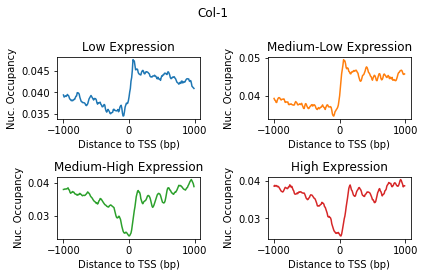

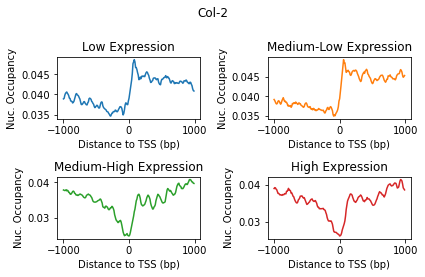

In [8]:
#Subsection data
Col1_low = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[4].tolist()
Col1_medlow = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[3].tolist()
Col1_med = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[2].tolist()
Col1_medhigh = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[1].tolist()
Col1_high = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[0].tolist()
Col2_low = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[9].tolist()
Col2_medlow = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[8].tolist()
Col2_med = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[7].tolist()
Col2_medhigh = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[6].tolist()
Col2_high = profile_vals.drop(columns=['bins','Unnamed: 1']).iloc[5].tolist()

#Plot data
x_vals = np.arange(-1000,1000,10)

fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col1_low)
axs[0, 0].set_title('Low Expression')
axs[0, 1].plot(x_vals,Col1_medlow, 'tab:orange')
axs[0, 1].set_title('Medium-Low Expression')
axs[1, 0].plot(x_vals,Col1_medhigh, 'tab:green')
axs[1, 0].set_title('Medium-High Expression')
axs[1, 1].plot(x_vals,Col1_high, 'tab:red')
axs[1, 1].set_title('High Expression')
fig.suptitle('Col-1')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col2_low)
axs[0, 0].set_title('Low Expression')
axs[0, 1].plot(x_vals,Col2_medlow, 'tab:orange')
axs[0, 1].set_title('Medium-Low Expression')
axs[1, 0].plot(x_vals,Col2_medhigh, 'tab:green')
axs[1, 0].set_title('Medium-High Expression')
axs[1, 1].plot(x_vals,Col2_high, 'tab:red')
axs[1, 1].set_title('High Expression')
fig.suptitle('Col-2')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

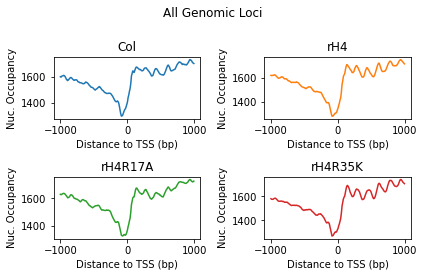

In [9]:
#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#sum all rows
rowsum = data_matrix.sum(axis=0)

#Split data by sample
Col_data = rowsum[0:200].tolist()
H4WT_data = rowsum[200:400].tolist()
R17A_data = rowsum[400:600].tolist()
R35K_data = rowsum[600:800].tolist()

#Plot data
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col_data)
axs[0, 0].set_title('Col')
axs[0, 1].plot(x_vals,H4WT_data, 'tab:orange')
axs[0, 1].set_title('rH4')
axs[1, 0].plot(x_vals,R17A_data, 'tab:green')
axs[1, 0].set_title('rH4R17A')
axs[1, 1].plot(x_vals,R35K_data, 'tab:red')
axs[1, 1].set_title('rH4R35K')
fig.suptitle('All Genomic Loci')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

In [10]:
data_matrix.loc[metadata['gene name'] == 'AT1G01010']

Col.mnase-fcnorm  Col.mnase-fcnorm.1  Col.mnase-fcnorm.2  \
0           0.01448             0.05168             0.05285   

   Col.mnase-fcnorm.3  Col.mnase-fcnorm.4  Col.mnase-fcnorm.5  \
0             0.07047             0.06381              0.0321   

   Col.mnase-fcnorm.6  Col.mnase-fcnorm.7  Col.mnase-fcnorm.8  \
0              0.0462             0.03132             0.03132   

   Col.mnase-fcnorm.9  ...  R35K.mnase-fcnorm.190  R35K.mnase-fcnorm.191  \
0             0.02975  ...                 0.1519                 0.1573   

   R35K.mnase-fcnorm.192  R35K.mnase-fcnorm.193  R35K.mnase-fcnorm.194  \
0                 0.1262                0.05175                0.05558   

   R35K.mnase-fcnorm.195  R35K.mnase-fcnorm.196  R35K.mnase-fcnorm.197  \
0                0.05085                0.04118                 0.0369   

   R35K.mnase-fcnorm.198  R35K.mnase-fcnorm.199  
0                 0.0324                 0.0405  

[1 rows x 800 columns]

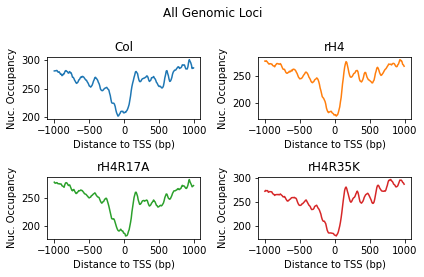

In [11]:
#Add cumulative sum of nucleosome occupancy over specific genes and plot profile

#Load list of genes to subset data by
base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/tpm/five_tpm_groups/"
filename = "H4WThigh.txt"
path_to_file = os.path.join(base_path, filename)
H4WThigh = pd.read_csv(path_to_file, sep='\t', header=None)
H4WThigh.columns = ['H4WT_high']

#select specific genes with indexing
indices = H4WThigh['H4WT_high'].tolist()
subset_data = data_matrix[metadata['gene name'].isin(indices)]

#sum all rows
rowsum = subset_data.sum(axis=0)

#Split data by sample
Col_data = rowsum[0:200].tolist()
H4WT_data = rowsum[200:400].tolist()
R17A_data = rowsum[400:600].tolist()
R35K_data = rowsum[600:800].tolist()

#Plot data
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col_data)
axs[0, 0].set_title('Col')
axs[0, 1].plot(x_vals,H4WT_data, 'tab:orange')
axs[0, 1].set_title('rH4')
axs[1, 0].plot(x_vals,R17A_data, 'tab:green')
axs[1, 0].set_title('rH4R17A')
axs[1, 1].plot(x_vals,R35K_data, 'tab:red')
axs[1, 1].set_title('rH4R35K')
fig.suptitle('All Genomic Loci')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

### Combine nucleosome positioning data with expression data from RNA-seq and subsection for one genotype

In [12]:
# Subset data to only include protein coding genes (Chr1-5)
# Load protein coding gene annotation file
base_path = "/Users/emmacorcoran/Desktop/annotations"
filename = "proteincoding_1to5.txt"
path_to_file = os.path.join(base_path, filename)
proteincoding_list = pd.read_csv(path_to_file, sep='\t', header=None)
proteincoding_list.columns = ['gene name','classification']

In [13]:
# Merge metadata with protein coding list
metadata = pd.merge(metadata, proteincoding_list, on="gene name")
metadata

Col.mnase-fcnorm  Col.mnase-fcnorm.1  Col.mnase-fcnorm.2  \
0               0.01448            0.051680            0.052850   
1               0.03171            0.043060            0.060290   
2               0.02349            0.030140            0.027800   
3               0.01331            0.023490            0.036410   
4               0.04933            0.056370            0.039540   
...                 ...                 ...                 ...   
27737           0.02349            0.019970            0.022710   
27738           0.01957            0.001174            0.003915   
27739           0.01292            0.013700            0.007830   
27740           0.02114            0.019180            0.022710   
27741           0.03915            0.046590            0.028580   

       Col.mnase-fcnorm.3  Col.mnase-fcnorm.4  Col.mnase-fcnorm.5  \
0                 0.07047             0.06381             0.03210   
1                 0.05951             0.05442             0.03367   
2                 0.02075             0.03132             0.02740   
3                 0.04815             0.06499             0.05481   
4                 0.04150             0.05481             0.05011   
...                   ...                 ...                 ...   
27737             0.03171             0.06812             0.07242   
27738             0.01566             0.01566             0.01566   
27739             0.00783             0.00274             0.00000   
27740             0.04972             0.07399             0.07830   
27741             0.03993             0.05246             0.04737   

       Col.mnase-fcnorm.6  Col.mnase-fcnorm.7  Col.mnase-fcnorm.8  \
0                 0.04620             0.03132            0.031320   
1                 0.02584             0.01566            0.015660   
2                 0.03171             0.03915            0.039150   
3                 0.04189             0.03171            0.035230   
4                 0.03484             0.03758            0.033670   
...                   ...                 ...                 ...   
27737             0.07321             0.06225            0.045020   
27738             0.01370             0.01448            0.015660   
27739             0.01566             0.03132            0.031320   
27740             0.07125             0.04424            0.006655   
27741             0.06342             0.04737            0.046980   

       Col.mnase-fcnorm.9  ...  R35K.mnase-fcnorm.192  R35K.mnase-fcnorm.193  \
0                 0.02975  ...                0.12620                0.05175   
1                 0.01174  ...                0.04140                0.03398   
2                 0.04424  ...                0.04635                0.03263   
3                 0.04580  ...                0.03600                0.02970   
4                 0.03328  ...                0.13500                0.12780   
...                   ...  ...                    ...                    ...   
27737             0.05285  ...                0.02183                0.00990   
27738             0.01566  ...                0.04230                0.05445   
27739             0.03915  ...                0.00585                0.00450   
27740             0.00000  ...                0.05963                0.03240   
27741             0.06655  ...                0.08100                0.08168   

       R35K.mnase-fcnorm.194  R35K.mnase-fcnorm.195  R35K.mnase-fcnorm.196  \
0                    0.05558                0.05085                0.04118   
1                    0.02093                0.03735                0.06368   
2                    0.01868                0.01688                0.01890   
3                    0.01530                0.01755                0.02678   
4                    0.12150                0.10460                0.07448   
...                      ...                    ...                    ...   
27737                0.00900         

In [14]:
#Load RNA-seq tpm expression data
base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/tpm/ordered_tpm_avg/"
filename = "H4WT_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
H4WT_tpm = pd.read_csv(path_to_file, sep='\t', header=0)
H4WT_tpm.columns = ['gene name','rep1','rep2']
H4WT_tpm['avg'] = H4WT_tpm[['rep1', 'rep2']].mean(axis=1)
H4WT_tpm = H4WT_tpm.sort_values(by=['gene name'])
H4WT_tpm

gene name      rep1      rep2       avg
16351  AT1G01010  0.358387  0.183340  0.270863
9507   AT1G01020  1.629708  1.668966  1.649337
10782  AT1G01030  1.454611  1.107450  1.281031
7443   AT1G01040  2.607951  2.191086  2.399518
22071  AT1G01046  0.000000  0.000000  0.000000
...          ...       ...       ...       ...
3935   AT5G67600  5.097406  4.942082  5.019744
9971   AT5G67610  1.747189  1.277511  1.512350
19565  AT5G67620  0.048432  0.056986  0.052709
7637   AT5G67630  2.341894  2.303106  2.322500
10713  AT5G67640  1.410545  1.190629  1.300587

[33056 rows x 4 columns]

In [15]:
#Merge metadata with tpm expression data and subset for one sample
all_subset_data = pd.merge(metadata, H4WT_tpm, on="gene name")
H4WT_subset_data = all_subset_data.loc[:,'H4WT.mnase-fcnorm':'H4WT.mnase-fcnorm.199']
H4WT_subset_data['gene name'] = all_subset_data['gene name']
H4WT_subset_data['expression'] = all_subset_data['avg']
H4WT_subset_data

H4WT.mnase-fcnorm  H4WT.mnase-fcnorm.1  H4WT.mnase-fcnorm.2  \
0               0.025460             0.031360             0.046580   
1               0.063040             0.047510             0.032300   
2               0.004658             0.006211             0.006211   
3               0.000311             0.012420             0.029810   
4               0.018940             0.000621             0.009005   
...                  ...                  ...                  ...   
27737           0.000000             0.009316             0.012730   
27738           0.018010             0.024840             0.024840   
27739           0.018940             0.016150             0.000311   
27740           0.023910             0.019250             0.012420   
27741           0.022670             0.018630             0.025770   

       H4WT.mnase-fcnorm.3  H4WT.mnase-fcnorm.4  H4WT.mnase-fcnorm.5  \
0                  0.05590              0.04192              0.03944   
1                  0.01397              0.02453              0.03757   
2                  0.01615              0.04037              0.04441   
3                  0.04347              0.04316              0.03261   
4                  0.03416              0.05372              0.05559   
...                    ...                  ...                  ...   
27737              0.02546              0.03105              0.02360   
27738              0.01956              0.01304              0.01553   
27739              0.00000              0.00000              0.00000   
27740              0.03757              0.06180              0.06521   
27741              0.03882              0.03882              0.04130   

       H4WT.mnase-fcnorm.6  H4WT.mnase-fcnorm.7  H4WT.mnase-fcnorm.8  \
0                  0.06149             0.068630             0.079810   
1                  0.03944             0.036330             0.030430   
2                  0.05559             0.051240             0.036020   
3                  0.01987             0.009626             0.013350   
4                  0.05279             0.028880             0.020500   
...                    ...                  ...                  ...   
27737              0.03851             0.038510             0.064590   
27738              0.02018             0.033850             0.031050   
27739              0.00000             0.004658             0.009005   
27740              0.07484             0.070180             0.040680   
27741              0.04285             0.042230             0.031050   

       H4WT.mnase-fcnorm.9  ...  H4WT.mnase-fcnorm.192  H4WT.mnase-fcnorm.193  \
0                  0.08167  ...               0.071420                0.03136   
1                  0.01832  ...               0.083220                0.06273   
2                  0.04844  ...               0.069560                0.07235   
3                  0.02391  ...               0.031670                0.03633   
4                  0.02298  ...               0.052480                0.04782   
...                    ...  ...                    ...                    ...   
27737              0.09937  ...               0.000932                0.01553   
27738              0.03323  ...               0.012420                0.01366   
27739              0.03292  ...               0.032610                0.02018   
27740              0.03726  ...               0.026400                0.02888   
27741              0.04223  ...               0.032300                0.03105   

       H4WT.mnase-fcnorm.194  H4WT.mnase-fcnorm.195  H4WT.mnase-fcnorm.196  \
0                    0.03416                0.01863               0.018630   
1                    0.03385                0.02981               0.049370   
2                    0.06801                0.05621               0.066450   
3                    0.05590                0.05683               0.058380   
4                    0.04192                0.02484               0.02484

In [16]:
### Add column to metadata with gene groups
# Make gene groups and count number of genes in each group
high_tpm = (H4WT_subset_data['expression']>=2.5)
print('Very high expression: ' + str(np.count_nonzero(high_tpm)))
medhigh_tpm = ((H4WT_subset_data['expression']>=0.5) & (H4WT_subset_data['expression']<2.5))
print('High expression: ' + str(np.count_nonzero(medhigh_tpm)))
medlow_tpm = ((H4WT_subset_data['expression']>0) & (H4WT_subset_data['expression']<0.5))
print('Low expression: ' + str(np.count_nonzero(medlow_tpm)))
low_tpm = (H4WT_subset_data['expression']==0)
print('Very low expression: ' + str(np.count_nonzero(low_tpm)))

# Add expression category column to metadata and fill in with values
n = len(H4WT_subset_data['expression'])
H4WT_subset_data['expression category'] = ["NA"] * n
H4WT_subset_data.loc[high_tpm==True, ['expression category']] = "very high"
H4WT_subset_data.loc[medhigh_tpm==True, ['expression category']] = "high"
H4WT_subset_data.loc[medlow_tpm==True, ['expression category']] = "low"
H4WT_subset_data.loc[low_tpm==True, ['expression category']] = "very low"
H4WT_subset_data

Very high expression: 7105
High expression: 7302
Low expression: 6803
Very low expression: 6532


H4WT.mnase-fcnorm  H4WT.mnase-fcnorm.1  H4WT.mnase-fcnorm.2  \
0               0.025460             0.031360             0.046580   
1               0.063040             0.047510             0.032300   
2               0.004658             0.006211             0.006211   
3               0.000311             0.012420             0.029810   
4               0.018940             0.000621             0.009005   
...                  ...                  ...                  ...   
27737           0.000000             0.009316             0.012730   
27738           0.018010             0.024840             0.024840   
27739           0.018940             0.016150             0.000311   
27740           0.023910             0.019250             0.012420   
27741           0.022670             0.018630             0.025770   

       H4WT.mnase-fcnorm.3  H4WT.mnase-fcnorm.4  H4WT.mnase-fcnorm.5  \
0                  0.05590              0.04192              0.03944   
1                  0.01397              0.02453              0.03757   
2                  0.01615              0.04037              0.04441   
3                  0.04347              0.04316              0.03261   
4                  0.03416              0.05372              0.05559   
...                    ...                  ...                  ...   
27737              0.02546              0.03105              0.02360   
27738              0.01956              0.01304              0.01553   
27739              0.00000              0.00000              0.00000   
27740              0.03757              0.06180              0.06521   
27741              0.03882              0.03882              0.04130   

       H4WT.mnase-fcnorm.6  H4WT.mnase-fcnorm.7  H4WT.mnase-fcnorm.8  \
0                  0.06149             0.068630             0.079810   
1                  0.03944             0.036330             0.030430   
2                  0.05559             0.051240             0.036020   
3                  0.01987             0.009626             0.013350   
4                  0.05279             0.028880             0.020500   
...                    ...                  ...                  ...   
27737              0.03851             0.038510             0.064590   
27738              0.02018             0.033850             0.031050   
27739              0.00000             0.004658             0.009005   
27740              0.07484             0.070180             0.040680   
27741              0.04285             0.042230             0.031050   

       H4WT.mnase-fcnorm.9  ...  H4WT.mnase-fcnorm.193  H4WT.mnase-fcnorm.194  \
0                  0.08167  ...                0.03136                0.03416   
1                  0.01832  ...                0.06273                0.03385   
2                  0.04844  ...                0.07235                0.06801   
3                  0.02391  ...                0.03633                0.05590   
4                  0.02298  ...                0.04782                0.04192   
...                    ...  ...                    ...                    ...   
27737              0.09937  ...                0.01553                0.01863   
27738              0.03323  ...                0.01366                0.02640   
27739              0.03292  ...                0.02018                0.03012   
27740              0.03726  ...                0.02888                0.03105   
27741              0.04223  ...                0.03105                0.02702   

       H4WT.mnase-fcnorm.195  H4WT.mnase-fcnorm.196  H4WT.mnase-fcnorm.197  \
0                    0.01863               0.018630               0.014910   
1                    0.02981               0.049370               0.049690   
2                    0.05621               0.066450               0.070490   
3                    0.05683               0.058380               0.041610   
4                    0.02484               0.024840               0.01987

In [17]:
#Load RNA-seq tpm expression data
base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/tpm/ordered_tpm_avg/"
filename = "R17A_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
R17A_tpm = pd.read_csv(path_to_file, sep='\t', header=0)
R17A_tpm.columns = ['gene name','rep1','rep2']
R17A_tpm['avg'] = R17A_tpm[['rep1', 'rep2']].mean(axis=1)
R17A_tpm = R17A_tpm.sort_values(by=['gene name'])

#Merge metadata with tpm expression data and subset for one sample
all_subset_data = pd.merge(metadata, R17A_tpm, on="gene name")
R17A_subset_data = all_subset_data.loc[:,'R17A.mnase-fcnorm':'R17A.mnase-fcnorm.199']
R17A_subset_data['gene name'] = all_subset_data['gene name']
R17A_subset_data['expression'] = all_subset_data['avg']

### Add column to metadata with gene groups
# Make gene groups and count number of genes in each group
high_tpm = (R17A_subset_data['expression']>=2.5)
print('Very high expression: ' + str(np.count_nonzero(high_tpm)))
medhigh_tpm = ((R17A_subset_data['expression']>=0.5) & (R17A_subset_data['expression']<2.5))
print('High expression: ' + str(np.count_nonzero(medhigh_tpm)))
medlow_tpm = ((R17A_subset_data['expression']>0) & (R17A_subset_data['expression']<0.5))
print('Low expression: ' + str(np.count_nonzero(medlow_tpm)))
low_tpm = (R17A_subset_data['expression']==0)
print('Very low expression: ' + str(np.count_nonzero(low_tpm)))

# Add expression category column to metadata and fill in with values
n = len(R17A_subset_data['expression'])
R17A_subset_data['expression category'] = ["NA"] * n
R17A_subset_data.loc[high_tpm==True, ['expression category']] = "very high"
R17A_subset_data.loc[medhigh_tpm==True, ['expression category']] = "high"
R17A_subset_data.loc[medlow_tpm==True, ['expression category']] = "low"
R17A_subset_data.loc[low_tpm==True, ['expression category']] = "very low"
R17A_subset_data

Very high expression: 8793
High expression: 6623
Low expression: 6270
Very low expression: 6056


R17A.mnase-fcnorm  R17A.mnase-fcnorm.1  R17A.mnase-fcnorm.2  \
0               0.008549             0.003538              0.01562   
1               0.023580             0.023580              0.02388   
2               0.007665             0.011790              0.01179   
3               0.053950             0.056310              0.02270   
4               0.005896             0.005896              0.00796   
...                  ...                  ...                  ...   
27737           0.000000             0.000000              0.00000   
27738           0.058960             0.053650              0.02919   
27739           0.037150             0.031840              0.02182   
27740           0.019460             0.011790              0.01179   
27741           0.016800             0.011790              0.02123   

       R17A.mnase-fcnorm.3  R17A.mnase-fcnorm.4  R17A.mnase-fcnorm.5  \
0                 0.033310              0.04127             0.043930   
1                 0.014740              0.01769             0.029480   
2                 0.014740              0.02034             0.027710   
3                 0.016800              0.02860             0.017980   
4                 0.034490              0.05424             0.064860   
...                    ...                  ...                  ...   
27737             0.007665              0.04098             0.041270   
27738             0.005012              0.00000             0.006486   
27739             0.022990              0.02948             0.017100   
27740             0.010020              0.01562             0.017690   
27741             0.027710              0.02653             0.035380   

       R17A.mnase-fcnorm.6  R17A.mnase-fcnorm.7  R17A.mnase-fcnorm.8  \
0                  0.03744              0.01975             0.011790   
1                  0.05749              0.06869             0.070160   
2                  0.03007              0.04334             0.035380   
3                  0.02535              0.03066             0.029480   
4                  0.06161              0.03626             0.016510   
...                    ...                  ...                  ...   
27737              0.05012              0.05660             0.046580   
27738              0.01916              0.02978             0.049230   
27739              0.02653              0.03420             0.029480   
27740              0.01769              0.01769             0.002064   
27741              0.03066              0.03832             0.066920   

       R17A.mnase-fcnorm.9  ...  R17A.mnase-fcnorm.193  R17A.mnase-fcnorm.194  \
0                 0.007075  ...               0.027710                0.04039   
1                 0.076650  ...               0.033900                0.01474   
2                 0.037150  ...               0.046870                0.02948   
3                 0.047760  ...               0.035080                0.01946   
4                 0.016800  ...               0.022990                0.03508   
...                    ...  ...                    ...                    ...   
27737             0.053060  ...               0.038030                0.04776   
27738             0.046580  ...               0.044810                0.04452   
27739             0.046280  ...               0.008549                0.01209   
27740             0.008844  ...               0.002653                0.01179   
27741             0.073700  ...               0.029480                0.03980   

       R17A.mnase-fcnorm.195  R17A.mnase-fcnorm.196  R17A.mnase-fcnorm.197  \
0                   0.034200               0.035970               0.031840   
1                   0.002948               0.005896               0.005896   
2                   0.024170               0.009728               0.015330   
3                   0.010020               0.005896               0.008549   
4                   0.048940               0.042160               0.03715

## Test Different Techniques to Reduce Dimensionality and Cluster Data

### Principal Component Analysis

In [18]:
# Make data frame
df = H4WT_subset_data.copy()
# Separate out the features
x = df.loc[:,'H4WT.mnase-fcnorm':'H4WT.mnase-fcnorm.199'].values
# Separate out the target
y = df.loc[:,['expression']].values
y_cat = df.loc[:,['expression category']].values
# Standardize the features
x = StandardScaler().fit_transform(x)

In [19]:
# Make secondary data frame
df2 = R17A_subset_data.copy()
# Separate out the features
x2 = df2.loc[:,'R17A.mnase-fcnorm':'R17A.mnase-fcnorm.199'].values
# Separate out the target
y2 = df2.loc[:,['expression']].values
y_cat2 = df2.loc[:,['expression category']].values
# Standardize the features
x2 = StandardScaler().fit_transform(x2)

In [20]:
# Run PCA to obtain first 2 principal components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, df[['expression']]], axis = 1)
finalDf = pd.concat([finalDf, df[['expression category']]], axis = 1)
finalDf

PC1       PC2       PC3  expression expression category
0     -2.370867 -1.065007  0.831566    0.270863                 low
1     -1.280101  0.212023  1.315914    1.649337                high
2     -1.643812 -1.134776  1.292237    1.281031                high
3     -1.417966  0.314075  1.448300    2.399518                high
4     -0.519793 -0.066920  0.549745    2.399518                high
...         ...       ...       ...         ...                 ...
27737 -0.576317 -0.041893 -0.862885    5.019744           very high
27738 -1.367990  1.716954 -0.325289    1.512350                high
27739 -2.193036 -0.111704  0.359830    0.052709                 low
27740 -1.085368  0.432518 -0.018870    2.322500                high
27741 -0.714418  1.677970 -0.729598    1.300587                high

[27742 rows x 5 columns]

<ipython-input-21-312a50551979>:8: RuntimeWarning: divide by zero encountered in log
  vals = ax.scatter(finalDf.loc[:, 'PC1'], finalDf.loc[:,'PC2'], s=10, c=np.log(y), cmap='cool')


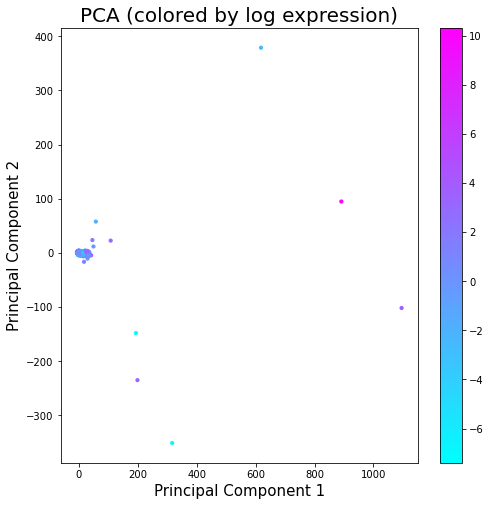

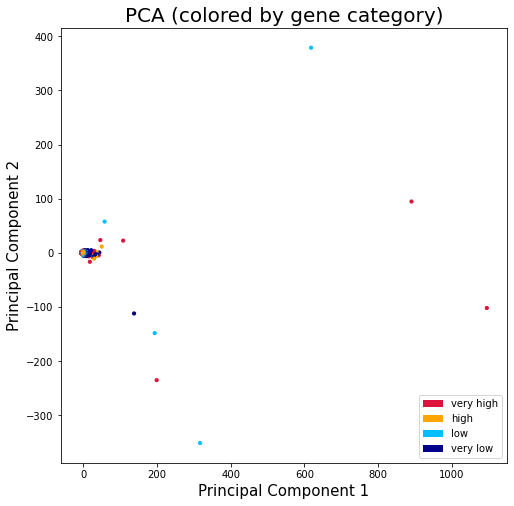

In [21]:
# Visualize 2D projection
# Color by log expression value
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA (colored by log expression)', fontsize = 20)
vals = ax.scatter(finalDf.loc[:, 'PC1'], finalDf.loc[:,'PC2'], s=10, c=np.log(y), cmap='cool')
cbar = fig.colorbar(vals)

# Color by expression category
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA (colored by gene category)', fontsize = 20)
colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
scatter = ax.scatter(finalDf.loc[:, 'PC1'], finalDf.loc[:,'PC2'], s=10, c=df['expression category'].map(colors))
#Add legend
classes = ['very high', 'high', 'low', 'very low']
class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=4)

In [22]:
# Print proportions of explained variance by each PC
pca.explained_variance_ratio_

array([0.50154332, 0.07438851, 0.05941107])

#### Conclusion from PCA
Almost all of the genes cluster together in one region. There are approximately 15 outliers from the main cluster - these genes vary in their expression level. This method is not incredibly useful for clustering.

### Testing different clustering methods: k-means and Louvain

In [23]:
# To make the computations feasible on laptop, subsample down to 3000 randomly selected genes
subsample_x, subsample_y, subsample_ycat, subsample_x2, subsample_y2, subsample_ycat2 = scprep.select.subsample(x, y, y_cat, x2, y2, y_cat2, n=3000)
#sample 1
subsample_data = pd.DataFrame(data = subsample_x)
subsample_data['expression'] = subsample_y
subsample_data['expression category'] = subsample_ycat
#sample 2
subsample_data2 = pd.DataFrame(data = subsample_x2)
subsample_data2['expression'] = subsample_y2
subsample_data2['expression category'] = subsample_ycat2

In [24]:
subsample_data

0         1         2         3         4         5         6  \
0    -0.866449 -0.583904 -0.209738  0.122257  0.118530 -0.157263 -0.477674   
1    -0.873443 -0.859166 -0.907441 -0.981493 -0.924521 -0.347673 -0.191168   
2    -0.201997 -0.308641 -0.318805 -0.106262 -0.106024  0.429680  0.437711   
3    -0.810488 -0.721513 -0.696679 -0.666136 -0.442984  0.289069  0.214759   
4     0.161768  0.221272  0.255554  0.098644  0.616217  1.479998  1.400504   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.539498  0.297069  0.589777  0.926647  0.768676  0.735667 -0.167335   
2996 -0.117982 -0.177881 -0.398616 -0.768614 -0.828240 -0.595605 -0.509451   
2997  0.028875  0.881946  0.873212  0.895162  0.616217 -0.636883 -0.732224   
2998 -0.572745 -0.645827 -0.762072 -0.642522 -0.675807 -0.694938 -0.644760   
2999 -0.334890 -0.432532 -0.616751 -0.027550  0.600196  0.710901  0.931024   

             7         8         9  ...       192       193       194  \
0    -0.718865 -0.670720 -0.399862  ... -0.180676 -0.100833  0.230530   
1    -0.184409 -0.247366 -0.477059  ...  0.238431  0.260627 -0.092309   
2     0.117694 -0.114533 -0.313811  ... -0.641491 -0.336687 -0.226710   
3     0.203011  0.151133 -0.709204  ... -0.400602 -0.296596 -0.339634   
4     1.287440  0.466511  0.046996  ...  0.468814  0.285683  0.106694   
...        ...       ...       ...  ...       ...       ...       ...   
2995 -0.773074 -0.861524 -0.984098  ...  0.709653  0.642131  0.537088   
2996 -0.029491  0.101154 -0.124830  ... -0.447656  0.014589  0.015246   
2997 -0.161209 -0.197653 -0.107675  ... -0.348150 -0.130900 -0.103047   
2998 -0.168943  0.815030  1.352983  ...  0.327481  0.687394  0.875861   
2999  0.791751  0.059727 -0.030478  ... -0.269557 -0.221265 -0.199865   

           195       196       197       198       199  expression  \
0     0.277170  0.362684 -0.008178 -0.653109 -0.274614    2.399518   
1    -0.009595 -0.539437 -0.863360 -0.713326 -0.492351   11.263234   
2     0.163695  0.210058 -0.188157 -0.262786 -0.441421    2.708744   
3    -0.457534 -0.400666 -0.323203 -0.277780 -0.260129    0.033711   
4    -0.117108 -0.581001 -0.713360 -0.705829 -0.775176    2.574984   
...        ...       ...       ...       ...       ...         ...   
2995  0.396608  0.674861  0.509536  0.518342  0.327434    0.018897   
2996  0.020216 -0.324242 -0.855871 -0.435457  0.218799   26.186094   
2997  0.020216  0.064360 -0.368137 -0.668344 -0.724340   20.053863   
2998  0.969946 -0.102343 -0.660937 -0.450451 -0.267372    2.451124   
2999 -0.218659 -0.525582 -0.885875 -0.840967 -0.572017    2.322500   

      expression category  
0                    high  
1               very high  
2               very high  
3                     low  
4               very high  
...                   ...  
2995                  low  
2996            very high  
2997            very high  
2998                 high  
2999                 high  

[3000 rows x 202 columns]

In [25]:
# Count number of genes in each expression category
# sample 1
print("Sample 1")
print('Very high expression: ' + str(np.count_nonzero(subsample_ycat=='very high')))
print('High expression: ' + str(np.count_nonzero(subsample_ycat=='high')))
print('Low expression: ' + str(np.count_nonzero(subsample_ycat=='low')))
print('Very low expression: ' + str(np.count_nonzero(subsample_ycat=='very low')))
# sample 2
print("Sample 2")
print('Very high expression: ' + str(np.count_nonzero(subsample_ycat2=='very high')))
print('High expression: ' + str(np.count_nonzero(subsample_ycat2=='high')))
print('Low expression: ' + str(np.count_nonzero(subsample_ycat2=='low')))
print('Very low expression: ' + str(np.count_nonzero(subsample_ycat2=='very low')))

Sample 1
Very high expression: 805
High expression: 774
Low expression: 752
Very low expression: 669
Sample 2
Very high expression: 971
High expression: 737
Low expression: 681
Very low expression: 611


In [26]:
# k-means
kmeans_labels_subsample = KMeans(n_clusters=5).fit_predict(subsample_x)
kmeans_labels_subsample2 = KMeans(n_clusters=5).fit_predict(subsample_x2)

In [27]:
# Louvain
#sample 1
# Convert to adjacency matrix
subsample_am = (np.dot(subsample_x, subsample_x.T) > 0).astype(int)
# Remove self loop
np.fill_diagonal(subsample_am, 0)
partition = community_louvain.best_partition(nx.from_numpy_matrix(subsample_am))
# Convert dictionary to array for use as labels on plot
louvain_labels_subsample = np.array(list(partition.items()))[:,1]

#sample 2
# Convert to adjacency matrix
subsample_am2 = (np.dot(subsample_x2, subsample_x2.T) > 0).astype(int)
# Remove self loop
np.fill_diagonal(subsample_am2, 0)
partition2 = community_louvain.best_partition(nx.from_numpy_matrix(subsample_am2))
# Convert dictionary to array for use as labels on plot
louvain_labels_subsample2 = np.array(list(partition2.items()))[:,1]

### Using tSNE for dimensionality reduction

In [28]:
# Visualize clusters with tSNE
tsne_embedded = TSNE(n_components=2, perplexity=30).fit_transform(subsample_am)
tsne_embedded2 = TSNE(n_components=2, perplexity=30).fit_transform(subsample_am2)

<ipython-input-29-f12a3a39bea1>:6: RuntimeWarning: divide by zero encountered in log
  vals = ax.scatter(tsne_embedded[:,0], tsne_embedded[:,1], s=10, c=np.log(subsample_y), cmap='cool')


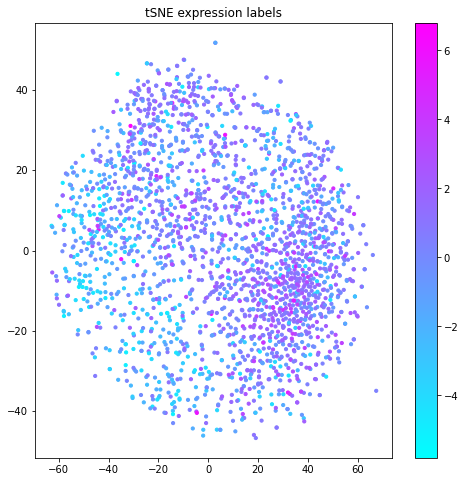

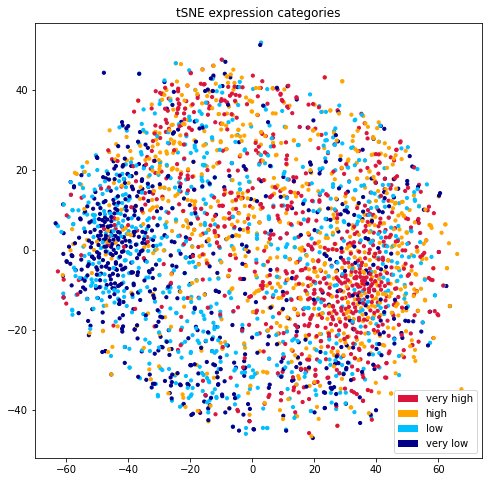

In [29]:
#Plot the data
# Color by expression level
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("tSNE expression labels")
vals = ax.scatter(tsne_embedded[:,0], tsne_embedded[:,1], s=10, c=np.log(subsample_y), cmap='cool')
cbar = fig.colorbar(vals)
#plt.show()
plt.savefig('10_02_2020 Plots/H4WT tSNE expression labels.png')

# Color by expression category
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("tSNE expression categories")
colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
scatter = ax.scatter(tsne_embedded[:,0], tsne_embedded[:,1], s=10, c=subsample_data['expression category'].map(colors))
#Add legend
classes = ['very high', 'high', 'low', 'very low']
class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=4)
plt.savefig('10_02_2020 Plots/H4WT tSNE expression categories.png')

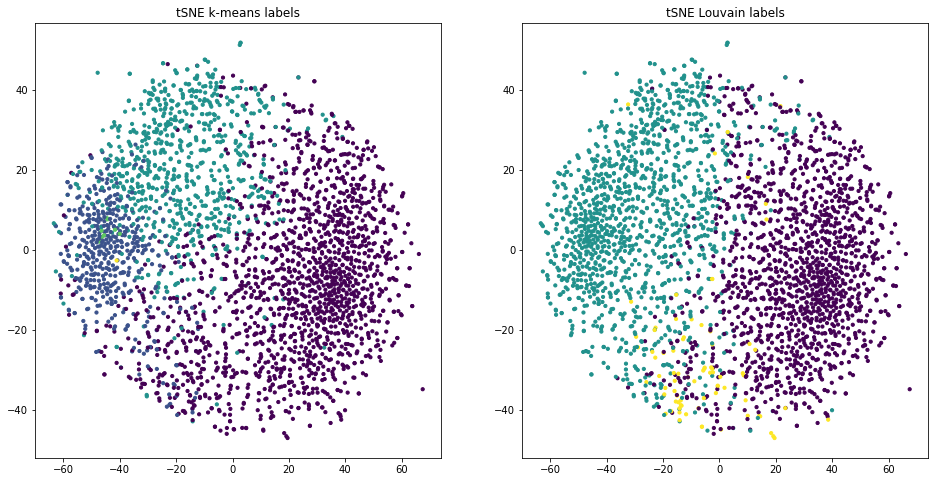

In [30]:
# Color by k-means clustering
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121) 
plt.title("tSNE k-means labels")
ax1.scatter(tsne_embedded[:,0], tsne_embedded[:,1], s=10, c=kmeans_labels_subsample)

# Color by Louvain clustering
ax2 = fig.add_subplot(122) 
plt.title("tSNE Louvain labels")
ax2.scatter(tsne_embedded[:,0], tsne_embedded[:,1], s=10, c=louvain_labels_subsample)

plt.savefig('10_02_2020 Plots/H4 WT tSNE clustering labels.png')

<ipython-input-31-dedbced9c8f3>:6: RuntimeWarning: divide by zero encountered in log
  vals = ax.scatter(tsne_embedded2[:,0], tsne_embedded2[:,1], s=10, c=np.log(subsample_y2), cmap='cool')


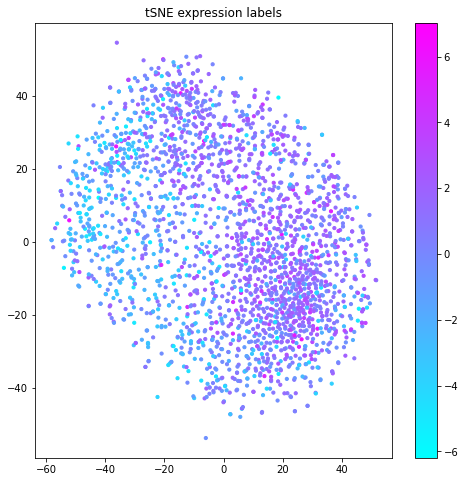

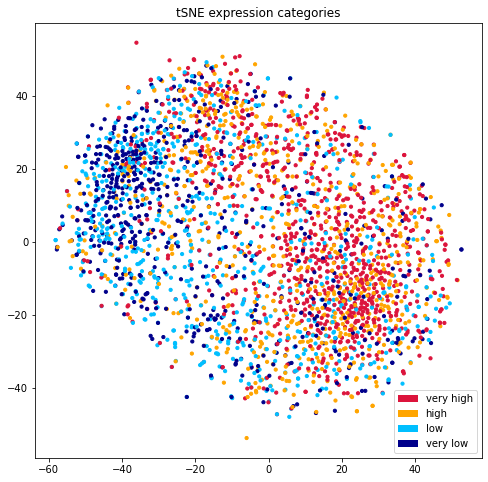

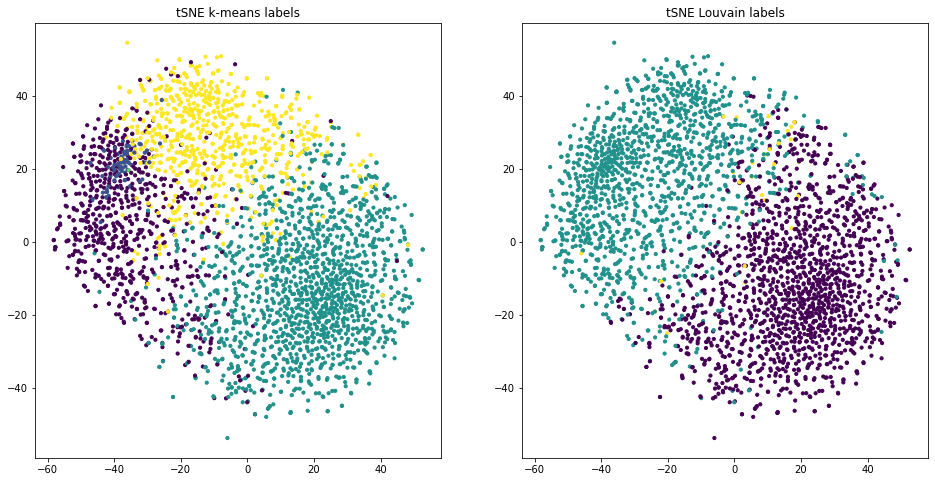

In [31]:
#Plot the data
# Color by expression level
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("tSNE expression labels")
vals = ax.scatter(tsne_embedded2[:,0], tsne_embedded2[:,1], s=10, c=np.log(subsample_y2), cmap='cool')
cbar = fig.colorbar(vals)
#plt.show()
plt.savefig('10_02_2020 Plots/R17A tSNE expression labels.png')

# Color by expression category
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("tSNE expression categories")
colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
scatter = ax.scatter(tsne_embedded2[:,0], tsne_embedded2[:,1], s=10, c=subsample_data2['expression category'].map(colors))
#Add legend
classes = ['very high', 'high', 'low', 'very low']
class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=4)
plt.savefig('10_02_2020 Plots/R17A tSNE expression categories.png')

# Color by k-means clustering
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121) 
plt.title("tSNE k-means labels")
ax1.scatter(tsne_embedded2[:,0], tsne_embedded2[:,1], s=10, c=kmeans_labels_subsample2)

# Color by Louvain clustering
ax2 = fig.add_subplot(122) 
plt.title("tSNE Louvain labels")
ax2.scatter(tsne_embedded2[:,0], tsne_embedded2[:,1], s=10, c=louvain_labels_subsample2)

plt.savefig('10_02_2020 Plots/R17A tSNE clustering labels.png')

#### Conclusion from tSNE
There are not completely distinct clusters observed when using tSNE for dimensionality reduction, but when coloring the genes by clusters assigned from k-means or Louvain clustering, distinct clusters can be observed in the embedding. The clusters generated by tSNE and Louvain appear similar. Generally, certain regions on the embedding seem to correspond to more highly or more lowly expressed genes, but these regions are not entirely clearly defined. When comparing the mutant to the control sample, both samples seem to behave similarly in that more highly expressed and more lowly expressed genes cluster together on opposite ends of the manifold.

### Using PHATE for dimensionality reduction

In [32]:
# Visualize clusters with PHATE
# Apply PHATE with default parameters-sample 1
phate_op = phate.PHATE(verbose=False)
phate_embedded = phate_op.fit_transform(subsample_am)
# Apply PHATE with default parameters-sample 2
phate_embedded2 = phate_op.fit_transform(subsample_am2)

<ipython-input-33-04ae0e86ae5a>:6: RuntimeWarning: divide by zero encountered in log
  vals = ax.scatter(phate_embedded[:,0], phate_embedded[:,1], s=10, c=np.log(subsample_y), cmap='cool')


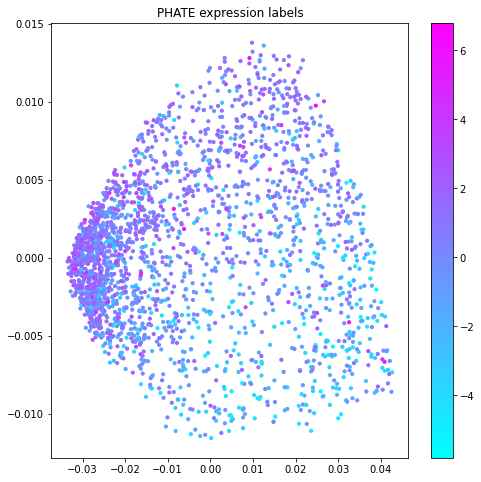

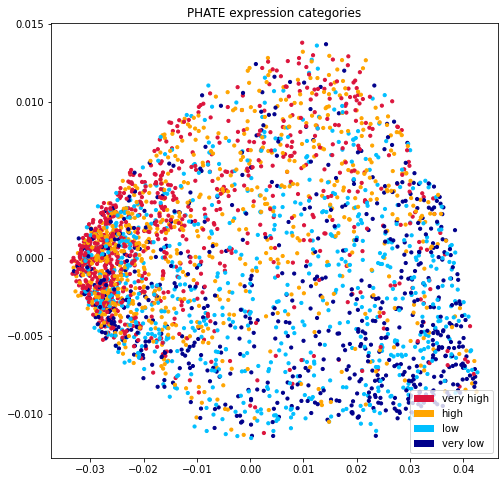

In [33]:
# Plot the data
# Color by expression level
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("PHATE expression labels")
vals = ax.scatter(phate_embedded[:,0], phate_embedded[:,1], s=10, c=np.log(subsample_y), cmap='cool')
cbar = fig.colorbar(vals)
plt.savefig('10_02_2020 Plots/H4WT PHATE expression labels.png')

# Color by expression category
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("PHATE expression categories")
colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
scatter = ax.scatter(phate_embedded[:,0], phate_embedded[:,1], s=10, c=subsample_data['expression category'].map(colors))
#Add legend
classes = ['very high', 'high', 'low', 'very low']
class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=4)
plt.savefig('10_02_2020 Plots/H4WT PHATE expression categories.png')

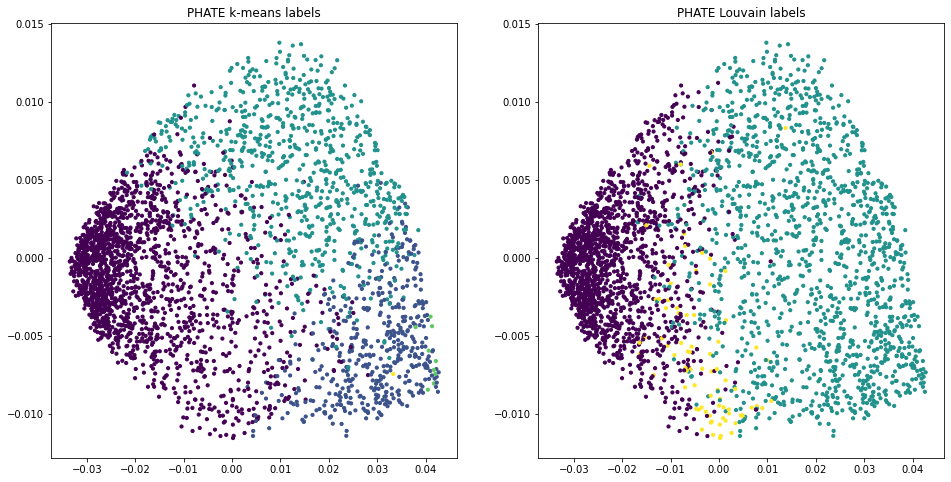

In [34]:
# Color by k-means clustering
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121) 
plt.title("PHATE k-means labels")
ax1.scatter(phate_embedded[:,0], phate_embedded[:,1], s=10, c=kmeans_labels_subsample)

# Color by Louvain clustering
ax2 = fig.add_subplot(122) 
plt.title("PHATE Louvain labels")
ax2.scatter(phate_embedded[:,0], phate_embedded[:,1], s=10, c=louvain_labels_subsample)
plt.savefig('10_02_2020 Plots/H4WT PHATE clustering labels.png')

<ipython-input-35-c18caaa54a0d>:6: RuntimeWarning: divide by zero encountered in log
  vals = ax.scatter(phate_embedded2[:,0], phate_embedded2[:,1], s=10, c=np.log(subsample_y2), cmap='cool')


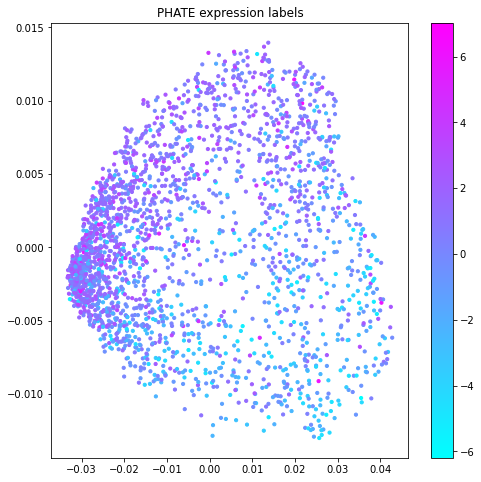

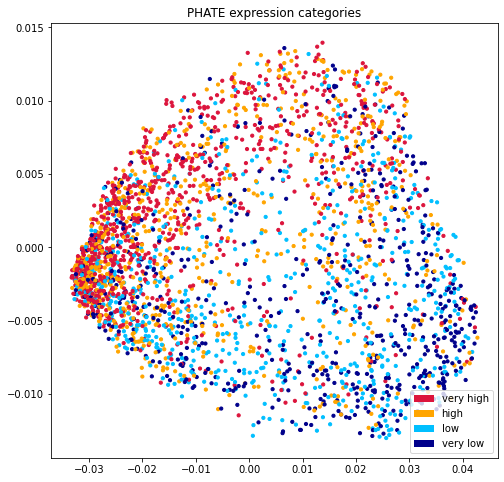

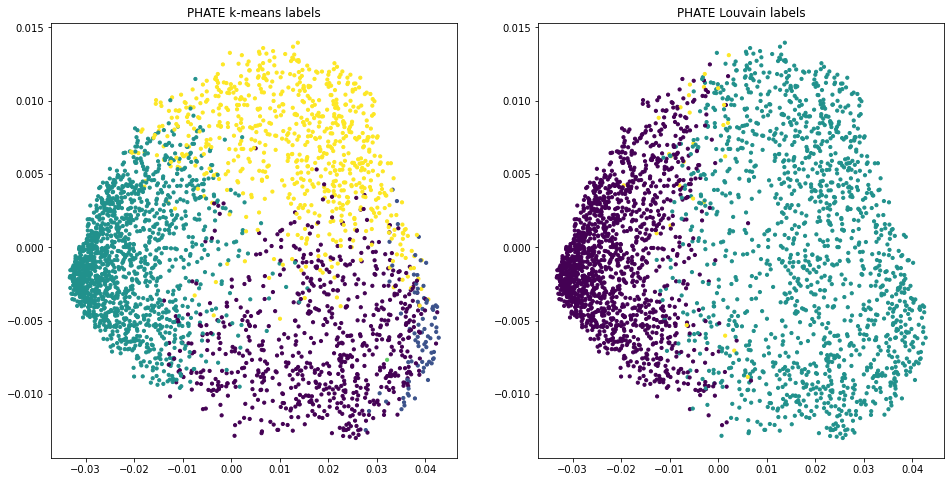

In [35]:
# Plot the data
# Color by expression level
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("PHATE expression labels")
vals = ax.scatter(phate_embedded2[:,0], phate_embedded2[:,1], s=10, c=np.log(subsample_y2), cmap='cool')
cbar = fig.colorbar(vals)
plt.savefig('10_02_2020 Plots/R17A PHATE expression labels.png')

# Color by expression category
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
plt.title("PHATE expression categories")
colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
scatter = ax.scatter(phate_embedded2[:,0], phate_embedded2[:,1], s=10, c=subsample_data2['expression category'].map(colors))
#Add legend
classes = ['very high', 'high', 'low', 'very low']
class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=4)
plt.savefig('10_02_2020 Plots/R17A PHATE expression categories.png')

# Color by k-means clustering
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121) 
plt.title("PHATE k-means labels")
ax1.scatter(phate_embedded2[:,0], phate_embedded2[:,1], s=10, c=kmeans_labels_subsample2)

# Color by Louvain clustering
ax2 = fig.add_subplot(122) 
plt.title("PHATE Louvain labels")
ax2.scatter(phate_embedded2[:,0], phate_embedded2[:,1], s=10, c=louvain_labels_subsample2)
plt.savefig('10_02_2020 Plots/R17A PHATE clustering labels.png')

#### Conclusion from PHATE
Similar to tSNE, there are not completely distinct clusters observed when using PHATE for dimensionality reduction, but when coloring the genes by clusters assigned from k-means or Louvain clustering, the distinct clusters can be observed in the embedding. Generally, certain regions on the embedding seem to correspond to more highly or more lowly expressed genes, but these regions are not clearly defined. However, a trajectory can be observed in the data manifold corresponding to a direction of more highly expressed genes. tSNE and PHATE appear to perform similarly at identifying clusters in the data related to gene expression.

## Visualizing results of clustering


### K-means Clustering Visualization

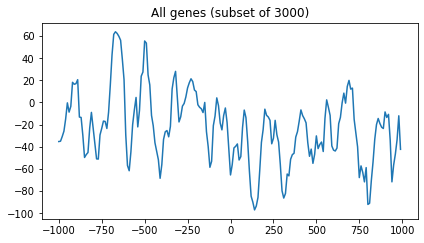

In [58]:
#Add cumulative sum of nucleosome occupancy over relevent genes and plot profile

#All genes
allgenes = subsample_data.iloc[:,range(200)]
#sum all rows
rowsum_all = allgenes.sum(axis=0).tolist()

#Plot data
x_vals = np.arange(-1000,1000,10)
plt.plot(x_vals, rowsum_all)
plt.title('All genes (subset of 3000)')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

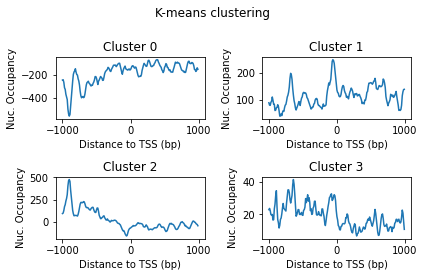

In [62]:
#Divide genes by k-means clustering label
cluster0 = subsample_data.iloc[kmeans_labels_subsample==0,range(200)]
cluster1 = subsample_data.iloc[kmeans_labels_subsample==1,range(200)]
cluster2 = subsample_data.iloc[kmeans_labels_subsample==2,range(200)]
cluster3 = subsample_data.iloc[kmeans_labels_subsample==3,range(200)]
#sum all rows
rowsum_k0 = cluster0.sum(axis=0).tolist()
rowsum_k1 = cluster1.sum(axis=0).tolist()
rowsum_k2 = cluster2.sum(axis=0).tolist()
rowsum_k3 = cluster3.sum(axis=0).tolist()

#Plot TSS metaprofiles
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, rowsum_k0)
axs[0, 0].set_title('Cluster 0')
axs[0, 1].plot(x_vals, rowsum_k1)
axs[0, 1].set_title('Cluster 1')
axs[1, 0].plot(x_vals, rowsum_k2)
axs[1, 0].set_title('Cluster 2')
axs[1, 1].plot(x_vals, rowsum_k3)
axs[1, 1].set_title('Cluster 3')
fig.suptitle('K-means clustering')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

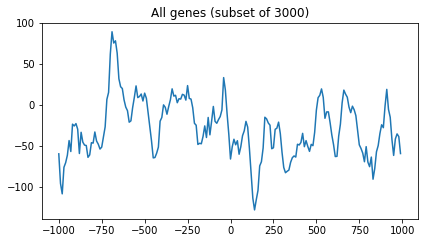

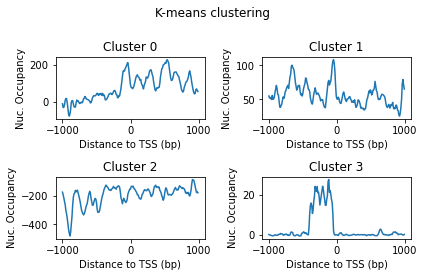

In [64]:
#Add cumulative sum of nucleosome occupancy over relevent genes and plot profile (sample 2)

#All genes
allgenes = subsample_data2.iloc[:,range(200)]
#sum all rows
rowsum_all = allgenes.sum(axis=0).tolist()

#Plot data
x_vals = np.arange(-1000,1000,10)
plt.plot(x_vals, rowsum_all)
plt.title('All genes (subset of 3000)')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

#Divide genes by k-means clustering label
cluster0 = subsample_data2.iloc[kmeans_labels_subsample2==0,range(200)]
cluster1 = subsample_data2.iloc[kmeans_labels_subsample2==1,range(200)]
cluster2 = subsample_data2.iloc[kmeans_labels_subsample2==2,range(200)]
cluster3 = subsample_data2.iloc[kmeans_labels_subsample2==3,range(200)]
#sum all rows
rowsum_k0 = cluster0.sum(axis=0).tolist()
rowsum_k1 = cluster1.sum(axis=0).tolist()
rowsum_k2 = cluster2.sum(axis=0).tolist()
rowsum_k3 = cluster3.sum(axis=0).tolist()

#Plot TSS metaprofiles
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, rowsum_k0)
axs[0, 0].set_title('Cluster 0')
axs[0, 1].plot(x_vals, rowsum_k1)
axs[0, 1].set_title('Cluster 1')
axs[1, 0].plot(x_vals, rowsum_k2)
axs[1, 0].set_title('Cluster 2')
axs[1, 1].plot(x_vals, rowsum_k3)
axs[1, 1].set_title('Cluster 3')
fig.suptitle('K-means clustering')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

### Expression Clustering Visualization

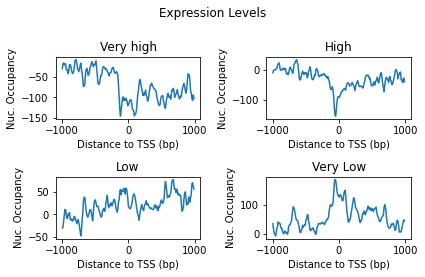

In [70]:
#Add cumulative sum of nucleosome occupancy over relevent genes and plot profile

#Divide genes by expression label
cluster0 = subsample_data.loc[subsample_data['expression category']=="very high",range(200)]
cluster1 = subsample_data.loc[subsample_data['expression category']=="high",range(200)]
cluster2 = subsample_data.loc[subsample_data['expression category']=="low",range(200)]
cluster3 = subsample_data.loc[subsample_data['expression category']=="very low",range(200)]
#sum all rows
rowsum_k0 = cluster0.sum(axis=0).tolist()
rowsum_k1 = cluster1.sum(axis=0).tolist()
rowsum_k2 = cluster2.sum(axis=0).tolist()
rowsum_k3 = cluster3.sum(axis=0).tolist()

#Plot TSS metaprofiles
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, rowsum_k0)
axs[0, 0].set_title('Very high')
axs[0, 1].plot(x_vals, rowsum_k1)
axs[0, 1].set_title('High')
axs[1, 0].plot(x_vals, rowsum_k2)
axs[1, 0].set_title('Low')
axs[1, 1].plot(x_vals, rowsum_k3)
axs[1, 1].set_title('Very Low')
fig.suptitle('Expression Levels')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

Text(0.5, 1.0, 'Very low')

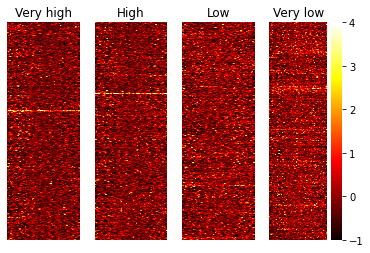

In [159]:
# Plot heatmaps over all genes corresponding to a specific category
fig,axn = plt.subplots(1, 4, sharex=True, sharey=True)

ax1 = sns.heatmap(np.array(cluster0), cmap='hot', ax=axn[0], vmin=-1, vmax=4, cbar=False, yticklabels=False, xticklabels=False)
ax1.set_title('Very high')
ax2 = sns.heatmap(np.array(cluster1), cmap='hot', ax=axn[1], vmin=-1, vmax=4, cbar=False, yticklabels=False, xticklabels=False)
ax2.set_title('High')
ax3 = sns.heatmap(np.array(cluster2), cmap='hot', ax=axn[2], vmin=-1, vmax=4, cbar=False, yticklabels=False, xticklabels=False)
ax3.set_title('Low')
ax4 = sns.heatmap(np.array(cluster3), cmap='hot', ax=axn[3], vmin=-1, vmax=4, cbar=True, yticklabels=False, xticklabels=False)
ax4.set_title('Very low')

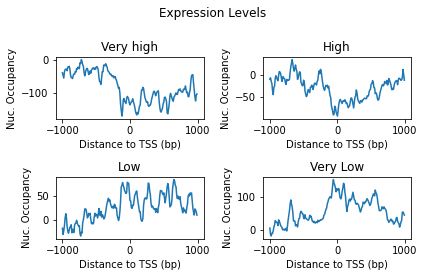

In [71]:
#Add cumulative sum of nucleosome occupancy over relevent genes and plot profile (sample 2)

#Divide genes by expression label
cluster0 = subsample_data2.loc[subsample_data2['expression category']=="very high",range(200)]
cluster1 = subsample_data2.loc[subsample_data2['expression category']=="high",range(200)]
cluster2 = subsample_data2.loc[subsample_data2['expression category']=="low",range(200)]
cluster3 = subsample_data2.loc[subsample_data2['expression category']=="very low",range(200)]
#sum all rows
rowsum_k0 = cluster0.sum(axis=0).tolist()
rowsum_k1 = cluster1.sum(axis=0).tolist()
rowsum_k2 = cluster2.sum(axis=0).tolist()
rowsum_k3 = cluster3.sum(axis=0).tolist()

#Plot TSS metaprofiles
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, rowsum_k0)
axs[0, 0].set_title('Very high')
axs[0, 1].plot(x_vals, rowsum_k1)
axs[0, 1].set_title('High')
axs[1, 0].plot(x_vals, rowsum_k2)
axs[1, 0].set_title('Low')
axs[1, 1].plot(x_vals, rowsum_k3)
axs[1, 1].set_title('Very Low')
fig.suptitle('Expression Levels')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])

### Conclusion
The different clustering methods are picking out patterns in nucleosome occupancy data related to overall nucleosome occupancy (either in the 5' NFR, the gene body, or both). There are also some distinctions between the different clusters regarding the number and/or height of the nucleosome peaks. </br>
When visualizing data by expression level category, trends related to overall nucleosome occupancy in the 5' NFR and the gene body seem to be largely responsible for distinguishing the expression categories from each other. These trends are shared between different genotypes.

## Building an Autoencoder to reduce the dimensionality of data into a 2D embedding

In [164]:
# Organize data into correct format and subsample
# Make data frame
df = H4WT_subset_data.copy()
# Separate out the features
x = df.loc[:,'H4WT.mnase-fcnorm':'H4WT.mnase-fcnorm.199'].values
# Separate out the target
y = df.loc[:,['expression']].values
y_cat = df.loc[:,['expression category']].values
## Create categorical labels
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['labels'] = labelencoder.fit_transform(df['expression category'])
labels = df.loc[:,['labels']].values
###Scale values
x = StandardScaler().fit_transform(x)

# Subsample data down to 10000 randomly selected genes
subsample_x, subsample_y, subsample_ycat, labels_subsample = scprep.select.subsample(x, y, y_cat, labels, n=10000)
subsample_data = pd.DataFrame(data = subsample_x)
subsample_data['expression'] = subsample_y
subsample_data['expression category'] = subsample_ycat
subsample_data['labels'] = labels_subsample
# Count number of genes in each expression category to make sure there's an even distribution among expression levels
print('Very high expression: ' + str(np.count_nonzero(subsample_ycat=='very high')))
print('High expression: ' + str(np.count_nonzero(subsample_ycat=='high')))
print('Low expression: ' + str(np.count_nonzero(subsample_ycat=='low')))
print('Very low expression: ' + str(np.count_nonzero(subsample_ycat=='very low')))

Very high expression: 2564
High expression: 2608
Low expression: 2463
Very low expression: 2365


In [165]:
subsample_data

0         1         2         3         4         5         6  \
0     0.546481  0.193790 -0.151459 -0.626780 -0.362879 -0.025174  0.023840   
1    -0.446835 -0.845401 -0.696679 -0.114134  0.391405  0.454713  0.365956   
2    -0.041175 -0.026508  0.109975  0.012060 -0.515337 -0.661916 -0.827709   
3    -0.866449 -0.859166 -0.224249 -0.027550  0.583917  0.959100  0.175037   
4    -0.390750 -0.625127 -0.762072 -0.894757 -0.996745 -1.025692 -0.772022   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.719558 -0.852285 -0.762072 -0.737078 -0.146077  0.950844  1.352839   
9996 -0.733545 -0.721513 -0.762072 -0.563556 -0.354868 -0.364184 -0.350309   
9997 -0.111000 -0.384217 -0.333316 -0.579298 -0.539369 -0.082963  0.334179   
9998  0.203663 -0.171010 -0.398616 -0.634651 -0.972672 -1.025692 -0.986876   
9999 -0.362820 -0.446273 -0.304294  0.004189  0.006382  0.074159  0.111227   

             7         8         9  ...       193       194       195  \
0    -0.052691 -0.214224 -0.554533  ...  0.325935 -0.151369 -0.242508   
1    -0.238544 -0.479623 -0.425595  ...  0.084908 -0.011600 -0.338097   
2    -0.579314 -0.521317 -0.545956  ... -0.477326 -0.506423 -0.344059   
3    -0.037224 -0.488175 -0.253769  ... -0.040536 -0.361111 -0.666540   
4    -0.439863 -0.056535  0.227399  ... -0.401995 -0.527899 -0.696390   
...        ...       ...       ...  ...       ...       ...       ...   
9995  2.032096  1.677241  0.992176  ... -0.386961 -0.146000 -0.152882   
9996 -0.494246  0.167704  0.536741  ... -0.336687 -0.275032 -0.170769   
9997  0.536048  0.640770  0.485276  ...  0.240581  0.246637  0.271208   
9998 -0.959001 -0.629026 -0.288079  ... -0.487348 -0.522530 -0.481383   
9999  0.094494 -0.197653  0.107038  ... -0.186186 -0.269663 -0.397719   

           196       197       198       199  expression  expression category  \
0     0.161343  0.187022  0.292952  0.175112    1.649337                 high   
1    -0.386811 -0.533380 -0.540655 -0.484875    2.399518                 high   
2    -0.456085 -0.345670  0.150269  0.211557   65.404648            very high   
3    -0.664353 -0.780859 -0.855985 -0.724340   19.943533            very high   
4    -0.803101 -0.345670 -0.105110 -0.093322    0.389092                  low   
...        ...       ...       ...       ...         ...                  ...   
9995  0.029500 -0.098288 -0.097613 -0.318068    1.755319                 high   
9996 -0.074410 -0.045623 -0.112606 -0.136776    4.983045            very high   
9997 -0.067483 -0.173179 -0.300271 -0.020665    0.816241                 high   
9998 -0.657425  0.186780  1.089074  0.936959    3.124505            very high   
9999 -0.796173 -0.525891 -0.232799 -0.238402    1.300587                 high   

      labels  
0          0  
1          0  
2          2  
3          2  
4          1  
...      ...  
9995       0  
9996       2  
9997       0  
9998       2  
9999       0  

[10000 rows x 203 columns]

In [166]:
#Create a training and testing split of the data (80-20 split) and generate minibatches from training data (shuffling the order of the points between epochs)
batch_size = 128

train = subsample_x[:4800,:]
train = torch.tensor(train)
train_labels = labels_subsample[:4800,:]
train_labels = torch.tensor(train_labels)
train_all = torch.utils.data.TensorDataset(train, train_labels)
test = subsample_x[4801:,:]
test = torch.tensor(test)
test_labels = labels_subsample[4801:,:]
test_labels = torch.tensor(test_labels)
test_all = torch.utils.data.TensorDataset(test, test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_all, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_all, batch_size=batch_size, shuffle=False)

In [167]:
# Define Autoencoder class 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.lin1 = nn.Linear(200, 1000)
        self.lin2 = nn.Linear(1000, 500)
        self.lin3 = nn.Linear(500, 250)
        self.lin4 = nn.Linear(250, 2)
        self.lin5 = nn.Linear(2, 250)
        self.lin6 = nn.Linear(250, 500)
        self.lin7 = nn.Linear(500, 1000)
        self.lin8 = nn.Linear(1000, 200)

    def encode(self, x):
        x = self.lin1(x)
        m = nn.Tanh()
        x = m(x)
        x = self.lin2(x)
        x = m(x)
        x = self.lin3(x)
        x = self.lin4(x)
        return x

    def decode(self, z):
        m1 = nn.Tanh()
        m2 = nn.Sigmoid()
        z = self.lin5(z)
        z = m1(z)
        z = self.lin6(z)
        z = m1(z)
        z = self.lin7(z)
        z = m1(z) 
        z = self.lin8(z)
        z = m2(z) 
        return z

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

### Training Autoencoder to Minimize Loss on Reconstruction of model input

In [287]:
# Set autoencoder parameters

#Learning rate
learning_rate = 0.01
# initialize the model
model = Autoencoder()
#Create a loss function set to Mean Squared Error
loss_fn = torch.nn.MSELoss()
# initialize ADAM optimizer and set the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Train the model to minimize loss on reconstruction of model input
#train the model for 100 epochs with a batch size of 128, and a learning rate of 0.01
num_epochs = 100
for epoch in range(num_epochs):
    # loop through each data point in the training set
    for data, targets in train_loader:
        optimizer.zero_grad()
            
        # run the model on the data
        model_input = data.float()
        out = model(model_input)

        # Calculate the loss    
        loss = loss_fn(out,model_input)

        # Find the gradients of our loss via backpropagation
        loss.backward()

        # Adjust accordingly with the optimizer
        optimizer.step()

    # Give status reports every 10 epochs
    if (epoch) % 10==0:
        print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
        print(f" Loss: {loss_fn(out,model_input)}. ")

 EPOCH 0. Progress: 0.0%. 
 Loss: 0.48043009638786316. 
 EPOCH 10. Progress: 10.0%. 
 Loss: 0.9947305917739868. 
 EPOCH 20. Progress: 20.0%. 
 Loss: 0.5631195306777954. 
 EPOCH 30. Progress: 30.0%. 
 Loss: 0.3074365556240082. 
 EPOCH 40. Progress: 40.0%. 
 Loss: 0.34139758348464966. 
 EPOCH 50. Progress: 50.0%. 
 Loss: 0.7678239345550537. 
 EPOCH 60. Progress: 60.0%. 
 Loss: 0.30526649951934814. 
 EPOCH 70. Progress: 70.0%. 
 Loss: 0.334019273519516. 
 EPOCH 80. Progress: 80.0%. 
 Loss: 0.34119415283203125. 
 EPOCH 90. Progress: 90.0%. 
 Loss: 0.37429481744766235. 


In [288]:
#After training the model, plot the 2D embedding of the test set. Color this with the different gene category labels and gene expression labels
#Generate embeddings
embeddings = torch.empty(0,2)
embed_labels = torch.empty(0)
for data, targets in test_loader:
    model_input = data.float()
    embed_toadd = model.encode(model_input)
    embeddings = torch.cat((embeddings,embed_toadd))
    embed_labels = torch.cat((embed_labels, targets))

<ipython-input-289-01a4b611cb80>:24: RuntimeWarning: divide by zero encountered in log
  vals = ax.scatter(tograph[:,0], tograph[:,1], s=10, c=np.log(subsample_y[4801:,]), cmap='cool')


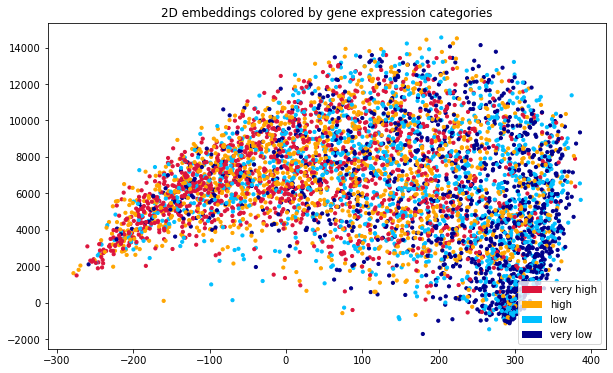

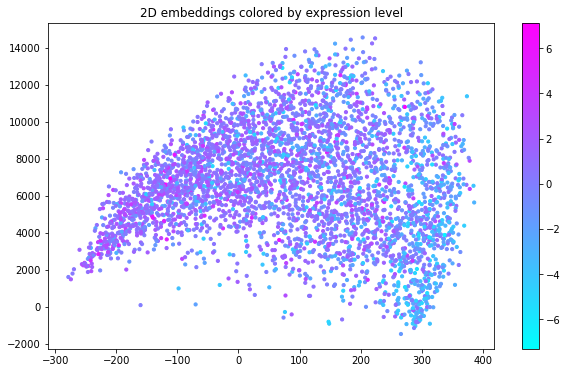

In [289]:
#Plot 2D embeddings from test data
tograph = embeddings.detach().numpy()
graph_labels = subsample_data.loc[4801:,]

#Color by expression categories
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.title("2D embeddings colored by gene expression categories")
colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
scatter = ax.scatter(tograph[:,0], tograph[:,1], s=10, c=graph_labels['expression category'].map(colors))
#Add legend
classes = ['very high', 'high', 'low', 'very low']
class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=4)
plt.savefig('10_02_2020 Plots/Autoencoder model_recon/expression categories test.png')

#Color by expression level
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.title("2D embeddings colored by expression level")
vals = ax.scatter(tograph[:,0], tograph[:,1], s=10, c=np.log(subsample_y[4801:,]), cmap='cool')
cbar = fig.colorbar(vals)
plt.savefig('10_02_2020 Plots/Autoencoder model_recon/expression level test.png')

<ipython-input-290-ca49f68ad4c6>:33: RuntimeWarning: divide by zero encountered in log
  vals = ax.scatter(tograph[:,0], tograph[:,1], s=10, c=np.log(subsample_y[:4800,]), cmap='cool')


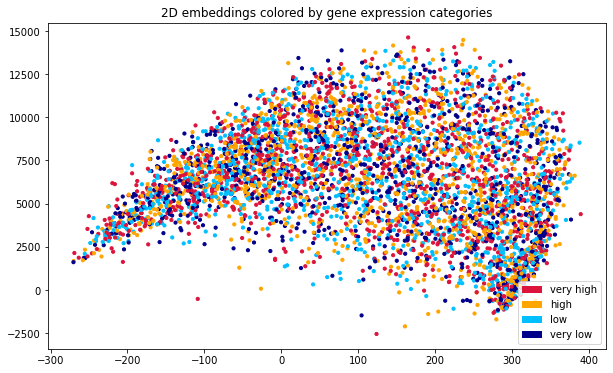

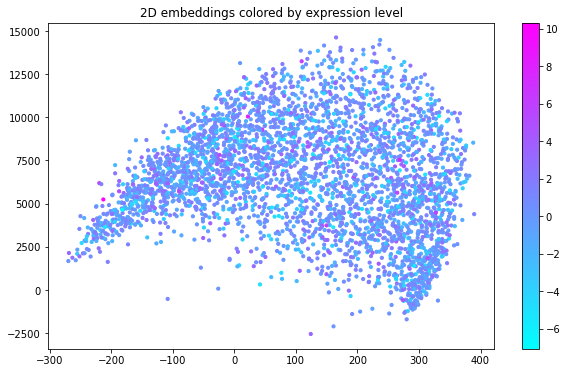

In [290]:
# Plot 2D embeddings from training data
#Generate embeddings
embeddings = torch.empty(0,2)
embed_labels = torch.empty(0)
for data, targets in train_loader:
    model_input = data.float()
    embed_toadd = model.encode(model_input)
    embeddings = torch.cat((embeddings,embed_toadd))
    embed_labels = torch.cat((embed_labels, targets))
    
tograph = embeddings.detach().numpy()
graph_labels = subsample_data.loc[:4799,]

#Color by expression categories
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.title("2D embeddings colored by gene expression categories")
colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
scatter = ax.scatter(tograph[:,0], tograph[:,1], s=10, c=graph_labels['expression category'].map(colors))
#Add legend
classes = ['very high', 'high', 'low', 'very low']
class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
recs = []
for i in range(0,len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
plt.legend(recs,classes,loc=4)
plt.savefig('10_02_2020 Plots/Autoencoder model_recon/expression categories train.png')

#Color by expression level
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.title("2D embeddings colored by expression level")
vals = ax.scatter(tograph[:,0], tograph[:,1], s=10, c=np.log(subsample_y[:4800,]), cmap='cool')
cbar = fig.colorbar(vals)
plt.savefig('10_02_2020 Plots/Autoencoder model_recon/expression level train.png')

In [291]:
# Produce side-by-side plots of several original and reconstructed nucleosome profiles
i=0
recon = torch.empty(0,200)
recon_labels = torch.empty(0)
ori_data = torch.empty(0,200)
for data, targets in test_loader:
    model_input = data.float()
    recon_toadd = model(model_input)
    recon = torch.cat((recon,recon_toadd))
    ori_data = torch.cat((ori_data, model_input))
    recon_labels = torch.cat((recon_labels,targets))
    i+=1
    if i>=2:
        break
        
#Generate 1 plot corresponding to several different genes (one per expression category)
recon_labels = recon_labels.detach().numpy()

cat0 = np.where(recon_labels==0)[0]
ori_0 = ori_data[cat0[0]]
recon_0 = recon[cat0[0]].detach().numpy()

cat1 = np.where(recon_labels==1)[0]
ori_1 = ori_data[cat1[0]].detach().numpy()
recon_1 = recon[cat1[0]].detach().numpy()

cat2 = np.where(recon_labels==2)[0]
ori_2 = ori_data[cat2[0]].detach().numpy()
recon_2 = recon[cat2[0]].detach().numpy()

cat3 = np.where(recon_labels==3)[0]
ori_3 = ori_data[cat3[0]].detach().numpy()
recon_3 = recon[cat3[0]].detach().numpy()

Text(0.5, 0.98, 'Autoencoder Reconstructions - Very low')

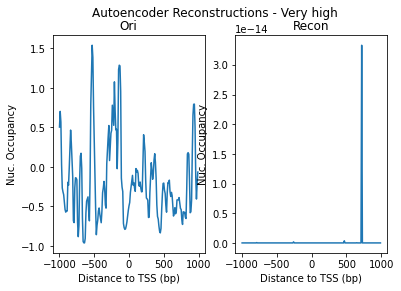

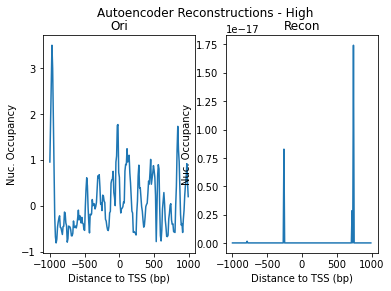

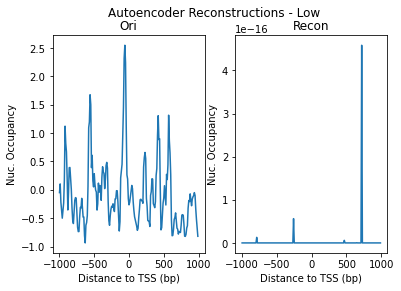

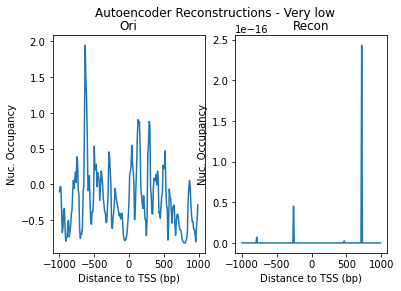

In [292]:
#Produce side-by-side plots corresponding to one original and reconstructed gene from each expression category
x_vals = np.arange(-1000,1000,10)

fig, axs = plt.subplots(1, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0].plot(x_vals, ori_0)
axs[0].set_title('Ori')
axs[1].plot(x_vals, recon_0)
axs[1].set_title('Recon')
fig.suptitle('Autoencoder Reconstructions - Very high')

fig, axs = plt.subplots(1, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0].plot(x_vals, ori_1)
axs[0].set_title('Ori')
axs[1].plot(x_vals, recon_1)
axs[1].set_title('Recon')
fig.suptitle('Autoencoder Reconstructions - High')

fig, axs = plt.subplots(1, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0].plot(x_vals, ori_2)
axs[0].set_title('Ori')
axs[1].plot(x_vals, recon_2)
axs[1].set_title('Recon')
fig.suptitle('Autoencoder Reconstructions - Low')

fig, axs = plt.subplots(1, 2)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0].plot(x_vals, ori_3)
axs[0].set_title('Ori')
axs[1].plot(x_vals, recon_3)
axs[1].set_title('Recon')
fig.suptitle('Autoencoder Reconstructions - Very low')

#### Conclusion
When training the autoencoder to minimize loss on model reconstruction, points do seem to generally cluster into certain regions in the latent space corresponding to their expression level, but similar to PHATE and tSNE, the different regions are not discrete. When visualizing the decoded input of the autoencoder, it appears that the autoencoder is essentially identifying 1-3 major peaks in the data rather than reconstructing all of the nucleosome peaks. In general, these unsupervised dimensionality reduction techniques seem to succeed at pulling out features of the data that can generally correspond to a specific expression level, but the dimensionally reduced data always appear very noisy. This trend is likely observed because many factors other than nucleosome positioning are responsible for determining the expression level of a gene, and moreover, the goal of these methods is not to cluster the data based on expression level. A model that takes the expression level for each gene into account may help the neural network pull out features in the nucleosome positioning data that are more relevant to gene expression.

## Training Feed-Forward Neural Network to Minimize Loss on Assignation of Gene Expression Category (Logistic Regression Classifier)

### Separated genes into 4 categories corresponding to expression level

In [172]:
#Define Feed Forward Neural Network Class
class FeedForwardNet(nn.Module):
    """ Simple feed forward network with one hidden layer."""
    
    def __init__(self): # initialize the model
        super(FeedForwardNet, self).__init__() # call for the parent class to initialize
        hidden_width = 128
        # define the weight and the bias for the input layer
        #initialize with samples from a uniform random distribution in the interval of [-1/sqrt(output_dimension), 1/sqrt(output_dimension)]
        W1_init = (torch.rand(200,hidden_width)-0.5)*(2/np.sqrt(200))
        b1_init = (torch.rand(hidden_width)-0.5)*(2/np.sqrt(200))
        self.W1 = nn.Parameter(W1_init) 
        self.b1 = nn.Parameter(b1_init)
        
        # Create one hidden layer (with 128 units) between the input and output by creating another weight and bias variable.
        W2_init = (torch.rand(hidden_width,4)-0.5)*(2/np.sqrt(hidden_width))
        b2_init = (torch.rand(4)-0.5)*(2/np.sqrt(hidden_width))
        self.W2 = nn.Parameter(W2_init) 
        self.b2 = nn.Parameter(b2_init)

    def forward(self, x):
        """
        function that will be executed when we call the logistic regression on data
        INPUT:
            x, MNase-seq profile represented as tensor of shape 200
        OUTPUT:
            predictions, a tensor of shape 4
        """
        a1 = x@self.W1 + self.b1
        
        #Relu non-linearity before hidden layer
        m = nn.ReLU()
        h1 = m(a1)
        predictions = h1@self.W2 + self.b2
        
        return predictions

In [173]:
#Define functions to train and evaluate neural network
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 200
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            targets = targets.flatten()
            optimizer.zero_grad()
            
            # run the model on the data
            model_input = data.float()
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out,targets)   #for feed-forward neural network  

            # Find the gradients of our loss via backpropagation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 10 epochs
        if (epoch+1) % 10==0:
            print(f" EPOCH {epoch+1}. Progress: {epoch/num_epochs*100}%. ")
            #print(f" Loss: {loss_fn(out,model_input)}. ") #for autoencoder
            print(f" Train accuracy: {evaluate(model,train_loader)}. Test accuracy: {evaluate(model,test_loader)}") #for feed-forward NN
            
    
def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropagation, which makes the model run much more quickly.
        correct=0
        total=0
        # Iterate through dataset
        for data, targets in evaluation_set:
            targets = targets.flatten()
            model_input = data.float()
            # Forward pass to get the outputs
            out = model(model_input)

            # Get predictions from the maximum value
            _, predicted = torch.max(out.data, 1)

            # Calculate total number of targets
            total = total+targets.size(0)
            
            # Sum total correct predictions
            correct = correct+(predicted == targets).sum()

        accuracy = 100. * correct/total
    return accuracy

In [174]:
# Initialize model and set parameters
model = FeedForwardNet()
#Create a loss function set to categorical cross-entropy
loss_fn = torch.nn.CrossEntropyLoss()
# initialize a stochastic gradient descent optimizer and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = learning_rate)
#train the model for 100 epochs with a batch size of 128, and a learning rate of 0.5
train(model, loss_fn, SGD, train_loader, test_loader)

 EPOCH 10. Progress: 4.5%. 
 Train accuracy: 39.27083206176758. Test accuracy: 34.737449645996094
 EPOCH 20. Progress: 9.5%. 
 Train accuracy: 43.02083206176758. Test accuracy: 39.372955322265625
 EPOCH 30. Progress: 14.499999999999998%. 
 Train accuracy: 45.66666793823242. Test accuracy: 41.64262390136719
 EPOCH 40. Progress: 19.5%. 
 Train accuracy: 46.72916793823242. Test accuracy: 41.73879623413086
 EPOCH 50. Progress: 24.5%. 
 Train accuracy: 48.0. Test accuracy: 42.31583023071289
 EPOCH 60. Progress: 29.5%. 
 Train accuracy: 48.52083206176758. Test accuracy: 42.21965789794922
 EPOCH 70. Progress: 34.5%. 
 Train accuracy: 49.54166793823242. Test accuracy: 42.35429763793945
 EPOCH 80. Progress: 39.5%. 
 Train accuracy: 50.35416793823242. Test accuracy: 42.29659652709961
 EPOCH 90. Progress: 44.5%. 
 Train accuracy: 51.45833206176758. Test accuracy: 42.662052154541016
 EPOCH 100. Progress: 49.5%. 
 Train accuracy: 52.3125. Test accuracy: 42.85439682006836
 EPOCH 110. Progress: 54.50

#### Conclusion
Approximately 42% accuracy can be achieved with the feed-forward neural network on the optimum settings for the test data set. The training data set reaches 62% accuracy. The neural network is potentially overfitting on the training data, but the neural network still does not achieve a very high accuracy on the training data. The neural network is likely leveling out at this accuracy value because a for a large percentage of the genes, their expression levels cannot be determined by their nucleosome positioning patterns alone. Since genes mainly seem to cluster into two categories (high or low expression), rather than four categories corresponding to expression level, testing the feed-forward neural network on genes separated into two categories may improve its accuracy.

### Separated genes into two categories corresponding to expression level

In [323]:
### Add column to metadata with 2 gene groups
# Make gene groups and count number of genes in each group
one_tpm = (H4WT_subset_data['expression']>=0.5)
print('High expression: ' + str(np.count_nonzero(one_tpm)))
zero_tpm = (H4WT_subset_data['expression']<0.5)
print('Low expression: ' + str(np.count_nonzero(zero_tpm)))

# Add expression category column to metadata and fill in with values
n = len(H4WT_subset_data['expression'])
H4WT_subset_data['binary expression'] = 0 * n
H4WT_subset_data.loc[one_tpm==True, ['binary expression']] = 1
H4WT_subset_data

High expression: 14407
Low expression: 13335


H4WT.mnase-fcnorm  H4WT.mnase-fcnorm.1  H4WT.mnase-fcnorm.2  \
0               0.025460             0.031360             0.046580   
1               0.063040             0.047510             0.032300   
2               0.004658             0.006211             0.006211   
3               0.000311             0.012420             0.029810   
4               0.018940             0.000621             0.009005   
...                  ...                  ...                  ...   
27737           0.000000             0.009316             0.012730   
27738           0.018010             0.024840             0.024840   
27739           0.018940             0.016150             0.000311   
27740           0.023910             0.019250             0.012420   
27741           0.022670             0.018630             0.025770   

       H4WT.mnase-fcnorm.3  H4WT.mnase-fcnorm.4  H4WT.mnase-fcnorm.5  \
0                  0.05590              0.04192              0.03944   
1                  0.01397              0.02453              0.03757   
2                  0.01615              0.04037              0.04441   
3                  0.04347              0.04316              0.03261   
4                  0.03416              0.05372              0.05559   
...                    ...                  ...                  ...   
27737              0.02546              0.03105              0.02360   
27738              0.01956              0.01304              0.01553   
27739              0.00000              0.00000              0.00000   
27740              0.03757              0.06180              0.06521   
27741              0.03882              0.03882              0.04130   

       H4WT.mnase-fcnorm.6  H4WT.mnase-fcnorm.7  H4WT.mnase-fcnorm.8  \
0                  0.06149             0.068630             0.079810   
1                  0.03944             0.036330             0.030430   
2                  0.05559             0.051240             0.036020   
3                  0.01987             0.009626             0.013350   
4                  0.05279             0.028880             0.020500   
...                    ...                  ...                  ...   
27737              0.03851             0.038510             0.064590   
27738              0.02018             0.033850             0.031050   
27739              0.00000             0.004658             0.009005   
27740              0.07484             0.070180             0.040680   
27741              0.04285             0.042230             0.031050   

       H4WT.mnase-fcnorm.9  ...  H4WT.mnase-fcnorm.194  H4WT.mnase-fcnorm.195  \
0                  0.08167  ...                0.03416                0.01863   
1                  0.01832  ...                0.03385                0.02981   
2                  0.04844  ...                0.06801                0.05621   
3                  0.02391  ...                0.05590                0.05683   
4                  0.02298  ...                0.04192                0.02484   
...                    ...  ...                    ...                    ...   
27737              0.09937  ...                0.01863                0.01863   
27738              0.03323  ...                0.02640                0.01863   
27739              0.03292  ...                0.03012                0.03726   
27740              0.03726  ...                0.03105                0.03105   
27741              0.04223  ...                0.02702                0.02174   

       H4WT.mnase-fcnorm.196  H4WT.mnase-fcnorm.197  H4WT.mnase-fcnorm.198  \
0                   0.018630               0.014910               0.004347   
1                   0.049370               0.049690               0.053720   
2                   0.066450               0.070490               0.058690   
3                   0.058380               0.041610               0.014600   
4                   0.024840               0.019870               0.01925

In [324]:
# Organize data into correct format and subsample
# Make data frame
df = H4WT_subset_data.copy()
# Separate out the features
x = df.loc[:,'H4WT.mnase-fcnorm':'H4WT.mnase-fcnorm.199'].values
# Separate out the target
y = df.loc[:,['binary expression']].values
## Create categorical labels
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['labels'] = labelencoder.fit_transform(df['binary expression'])
labels = df.loc[:,['labels']].values
###Scale values
x = StandardScaler().fit_transform(x)

In [325]:
#Create a training and testing split of the data (80-20 split) and generate minibatches from training data (shuffling the order of the points between epochs)
batch_size = 128

train = x[:22200,:]
train = torch.tensor(train)
train_labels = y[:22200,:]
train_labels = torch.tensor(train_labels)
train_all = torch.utils.data.TensorDataset(train, train_labels)
test = x[22201:,:]
test = torch.tensor(test)
test_labels = y[22201:,:]
test_labels = torch.tensor(test_labels)
test_all = torch.utils.data.TensorDataset(test, test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_all, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_all, batch_size=batch_size, shuffle=False)

In [329]:
#Define Feed Forward Neural Network Class
class FeedForwardNet(nn.Module):
    """ Simple feed forward network with one hidden layer."""
    
    def __init__(self): # initialize the model
        super(FeedForwardNet, self).__init__() # call for the parent class to initialize
        hidden_width = 128
        # define the weight and the bias for the input layer
        #initialize with samples from a uniform random distribution in the interval of [-1/sqrt(output_dimension), 1/sqrt(output_dimension)]
        W1_init = (torch.rand(200,hidden_width)-0.5)*(2/np.sqrt(200))
        b1_init = (torch.rand(hidden_width)-0.5)*(2/np.sqrt(200))
        self.W1 = nn.Parameter(W1_init) 
        self.b1 = nn.Parameter(b1_init)
        
        # Create one hidden layer (with 128 units) between the input and output by creating another weight and bias variable.
        W2_init = (torch.rand(hidden_width,2)-0.5)*(2/np.sqrt(hidden_width))
        b2_init = (torch.rand(2)-0.5)*(2/np.sqrt(hidden_width))
        self.W2 = nn.Parameter(W2_init) 
        self.b2 = nn.Parameter(b2_init)

    def forward(self, x):
        """
        function that will be executed when we call the logistic regression on data
        INPUT:
            x, MNase-seq profile represented as tensor of shape 200
        OUTPUT:
            predictions, a tensor of shape 2
        """
        a1 = x@self.W1 + self.b1
        
        #Relu non-linearity before hidden layer
        m = nn.ReLU()
        h1 = m(a1)
        predictions = h1@self.W2 + self.b2
        
        return predictions

In [330]:
#Define functions to train and evaluate neural network
def train(model, loss_fn, optimizer, train_loader, test_loader):
    """
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 200
    for epoch in range(num_epochs):
        # loop through each data point in the training set
        for data, targets in train_loader:
            targets = targets.flatten()
            optimizer.zero_grad()
            
            # run the model on the data
            model_input = data.float()
            out = model(model_input)

            # Calculate the loss
            loss = loss_fn(out,targets)   #for feed-forward neural network  

            # Find the gradients of our loss via backpropagation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 10 epochs
        if (epoch+1) % 10==0:
            print(f" EPOCH {epoch+1}. Progress: {epoch/num_epochs*100}%. ")
            #print(f" Loss: {loss_fn(out,model_input)}. ") #for autoencoder
            print(f" Train accuracy: {evaluate(model,train_loader)}. Test accuracy: {evaluate(model,test_loader)}") #for feed-forward NN
            
    
def evaluate(model, evaluation_set):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropagation, which makes the model run much more quickly.
        correct=0
        total=0
        # Iterate through dataset
        for data, targets in evaluation_set:
            targets = targets.flatten()
            model_input = data.float()
            # Forward pass to get the outputs
            out = model(model_input)

            # Get predictions from the maximum value
            _, predicted = torch.max(out.data, 1)

            # Calculate total number of targets
            total = total+targets.size(0)
            
            # Sum total correct predictions
            correct = correct+(predicted == targets).sum()

        accuracy = 100. * correct/total
    return accuracy

In [331]:
# Initialize model and set parameters
model = FeedForwardNet()
#Create a loss function set to categorical cross-entropy
loss_fn = torch.nn.CrossEntropyLoss()
# initialize a stochastic gradient descent optimizer and set the learning rate
SGD = torch.optim.SGD(model.parameters(), lr = learning_rate)
#train the model for 100 epochs with a batch size of 128, and a learning rate of 0.5
train(model, loss_fn, SGD, train_loader, test_loader)

 EPOCH 10. Progress: 4.5%. 
 Train accuracy: 75.0990982055664. Test accuracy: 74.8601303100586
 EPOCH 20. Progress: 9.5%. 
 Train accuracy: 76.28378295898438. Test accuracy: 75.63616943359375
 EPOCH 30. Progress: 14.499999999999998%. 
 Train accuracy: 77.17567443847656. Test accuracy: 76.19563293457031
 EPOCH 40. Progress: 19.5%. 
 Train accuracy: 77.9639663696289. Test accuracy: 76.267822265625
 EPOCH 50. Progress: 24.5%. 
 Train accuracy: 78.409912109375. Test accuracy: 76.06929779052734
 EPOCH 60. Progress: 29.5%. 
 Train accuracy: 79.10810852050781. Test accuracy: 76.267822265625
 EPOCH 70. Progress: 34.5%. 
 Train accuracy: 79.61260986328125. Test accuracy: 75.9249267578125
 EPOCH 80. Progress: 39.5%. 
 Train accuracy: 79.95044708251953. Test accuracy: 75.9249267578125
 EPOCH 90. Progress: 44.5%. 
 Train accuracy: 80.4459457397461. Test accuracy: 75.85273742675781
 EPOCH 100. Progress: 49.5%. 
 Train accuracy: 80.909912109375. Test accuracy: 75.63616943359375
 EPOCH 110. Progress:

#### Conclusion
Approximately 74% accuracy can be achieved with the feed-forward neural network on the optimum settings for the test data set, while the training data set reaches 85% accuracy. This represents a marked improvement (~32%) over the neural network that categorized the genes into four expression categories. While utilizing fewer categories does ensure that the algorithm has a higher chance of assigning the correct classification by pure chance, the improvement seen with the 2-category classification is still significant. These data indicate that nucleosome positioning patterns associated with protein-coding genes largely cluster into two main clusters corresponding to high or low expression, rather than four main clusters corresponding to very high, high, low, and very low expression.